## Machine Learning: Infrared Thermography Temperature Prediction 
### Malorie Iovino 33847140 
### 27 March, 2025 

In [4]:
!pip install xgboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 22.5 MB/s eta 0:00:00a 0:00:01


In [88]:
#Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, roc_auc_score, precision_recall_curve, auc
from sklearn.neural_network import MLPRegressor, MLPClassifier
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# Set display options for better readability
pd.set_option('display.max_columns', None)
pd.set_option('display.width', 1000)


### Loading Dataset

In [90]:
try:
    import ucimlrepo
except ImportError:
    !pip install ucimlrepo
    import ucimlrepo

# Import the dataset using the repository ID
from ucimlrepo import fetch_ucirepo

# Fetch dataset with ID 925 (Infrared Thermography Temperature Dataset)
thermography = fetch_ucirepo(id=925)

# Extract data and metadata
X = thermography.data.features
y = thermography.data.targets
df = pd.concat([X, y], axis=1)

print(f"Successfully loaded data from UCI ML Repository")
print(f"Dataset: {thermography.metadata.name}")
print(f"Dataset version: {thermography.metadata.version}")
print(f"Citation: {thermography.metadata.citation}")

print(f"Dataset dimensions: {df.shape}")

# Display the first few rows of the dataset
print("\nFirst 5 rows of the dataset:")
print(df.head())

# Check column names and data types
print("\nData types of columns:")
print(df.dtypes)

# Check for missing values
print("\nMissing values per column:")
print(df.isnull().sum())

# Basic statistics for numerical columns
print("\nBasic statistics:")
print(df.describe())

Successfully loaded data from UCI ML Repository
Dataset: Infrared Thermography Temperature
Dataset version: None
Citation: None
Dataset dimensions: (1020, 35)

First 5 rows of the dataset:
   Gender    Age                  Ethnicity  T_atm  Humidity  Distance  T_offset1  Max1R13_1  Max1L13_1  aveAllR13_1  aveAllL13_1    T_RC1  T_RC_Dry1  T_RC_Wet1  T_RC_Max1    T_LC1  T_LC_Dry1  T_LC_Wet1  T_LC_Max1     RCC1     LCC1  canthiMax1  canthi4Max1  T_FHCC1  T_FHRC1  T_FHLC1  T_FHBC1  T_FHTC1  T_FH_Max1  T_FHC_Max1   T_Max1    T_OR1  T_OR_Max1  aveOralF  aveOralM
0    Male  41-50                      White   24.0      28.0       0.8     0.7025    35.0300    35.3775      34.4000      34.9175  34.9850    34.9850    34.7625    35.0325  35.3375    35.3375    34.4850    35.3775  34.7850  34.4650     35.3775      35.3375  33.5775  33.4775  33.3725  33.4925  33.0025    34.5300     34.0075  35.6925  35.6350    35.6525     36.85     36.59
1  Female  31-40  Black or African-American   24.0      26.0   

### Data Preparation 

In [94]:
df['fever_OralF'] = (df['aveOralF'] >= 37.5).astype(int)
df['fever_OralM'] = (df['aveOralM'] >= 37.5).astype(int)

X = df.drop(['aveOralF', 'aveOralM', 'fever_OralF', 'fever_OralM'], axis=1)
y_reg_F = df['aveOralF']  # Regression target (Fast mode)
y_reg_M = df['aveOralM']  # Regression target (Monitor mode)
y_class_F = df['fever_OralF']  # Classification target (Fast mode)
y_class_M = df['fever_OralM']  # Classification target (Monitor mode)

# Identify numeric and categorical columns
numeric_columns = X.select_dtypes(include=['int64', 'float64']).columns
categorical_columns = X.select_dtypes(include=['object']).columns

print(f"\nNumeric features: {len(numeric_columns)}")
print(f"Categorical features: {len(categorical_columns)}")

# Create preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_columns)
    ])

# Split the data into training and testing sets
X_train, X_test, y_reg_F_train, y_reg_F_test, y_reg_M_train, y_reg_M_test, y_class_F_train, y_class_F_test, y_class_M_train, y_class_M_test = train_test_split(
    X, y_reg_F, y_reg_M, y_class_F, y_class_M, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")


Numeric features: 30
Categorical features: 3

Training set size: (816, 33)
Testing set size: (204, 33)


### Exploratory Data Analysis 

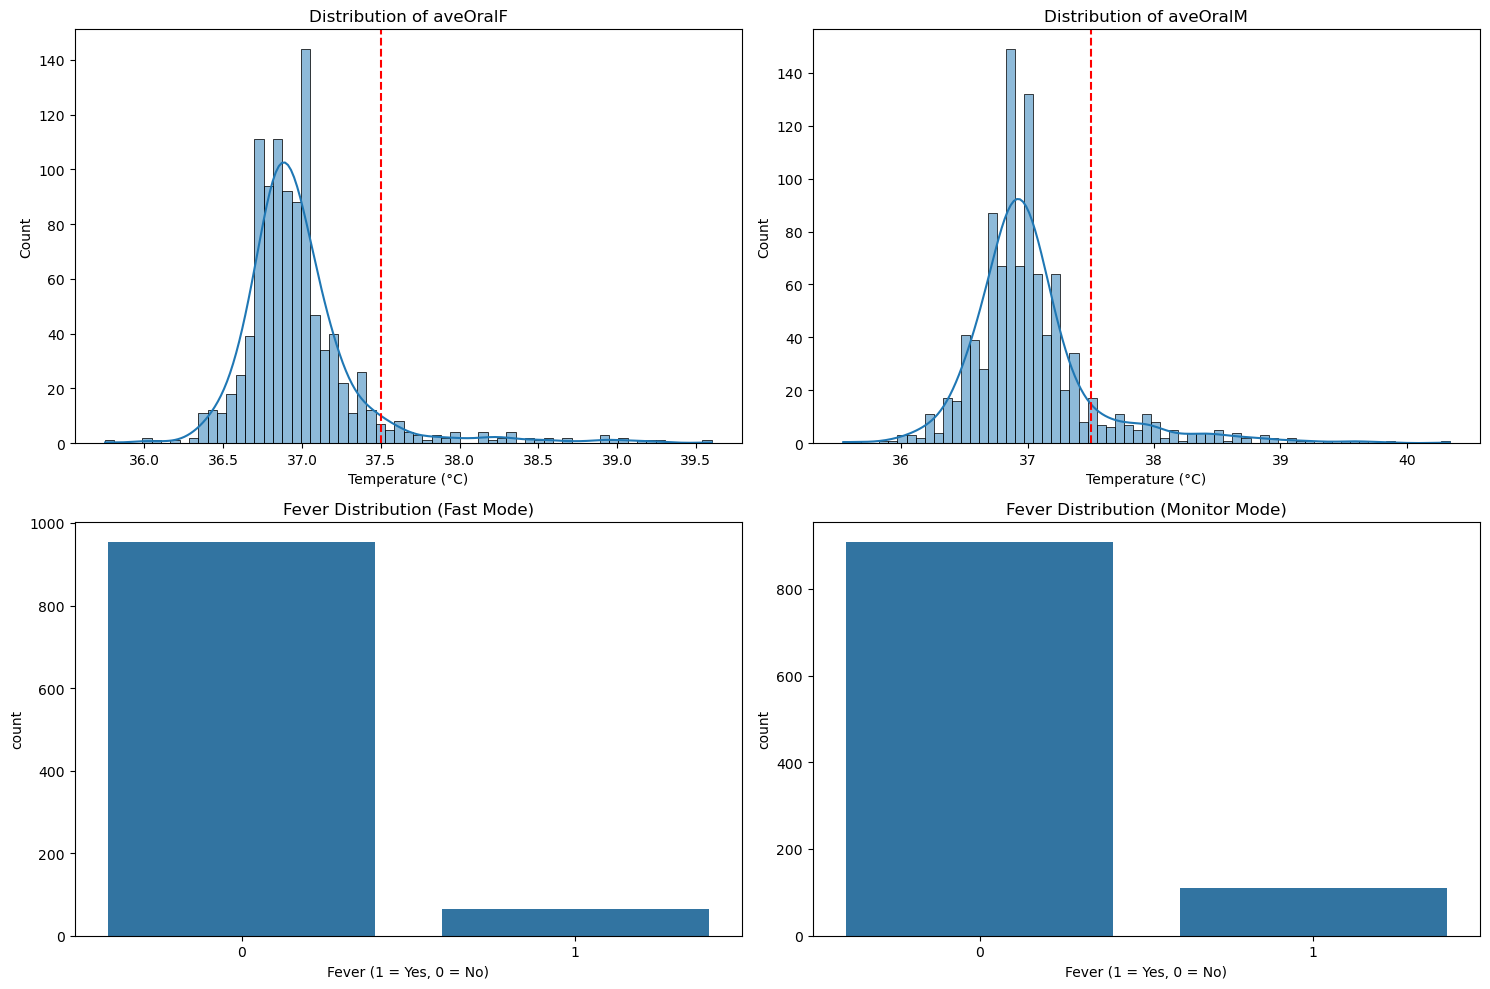

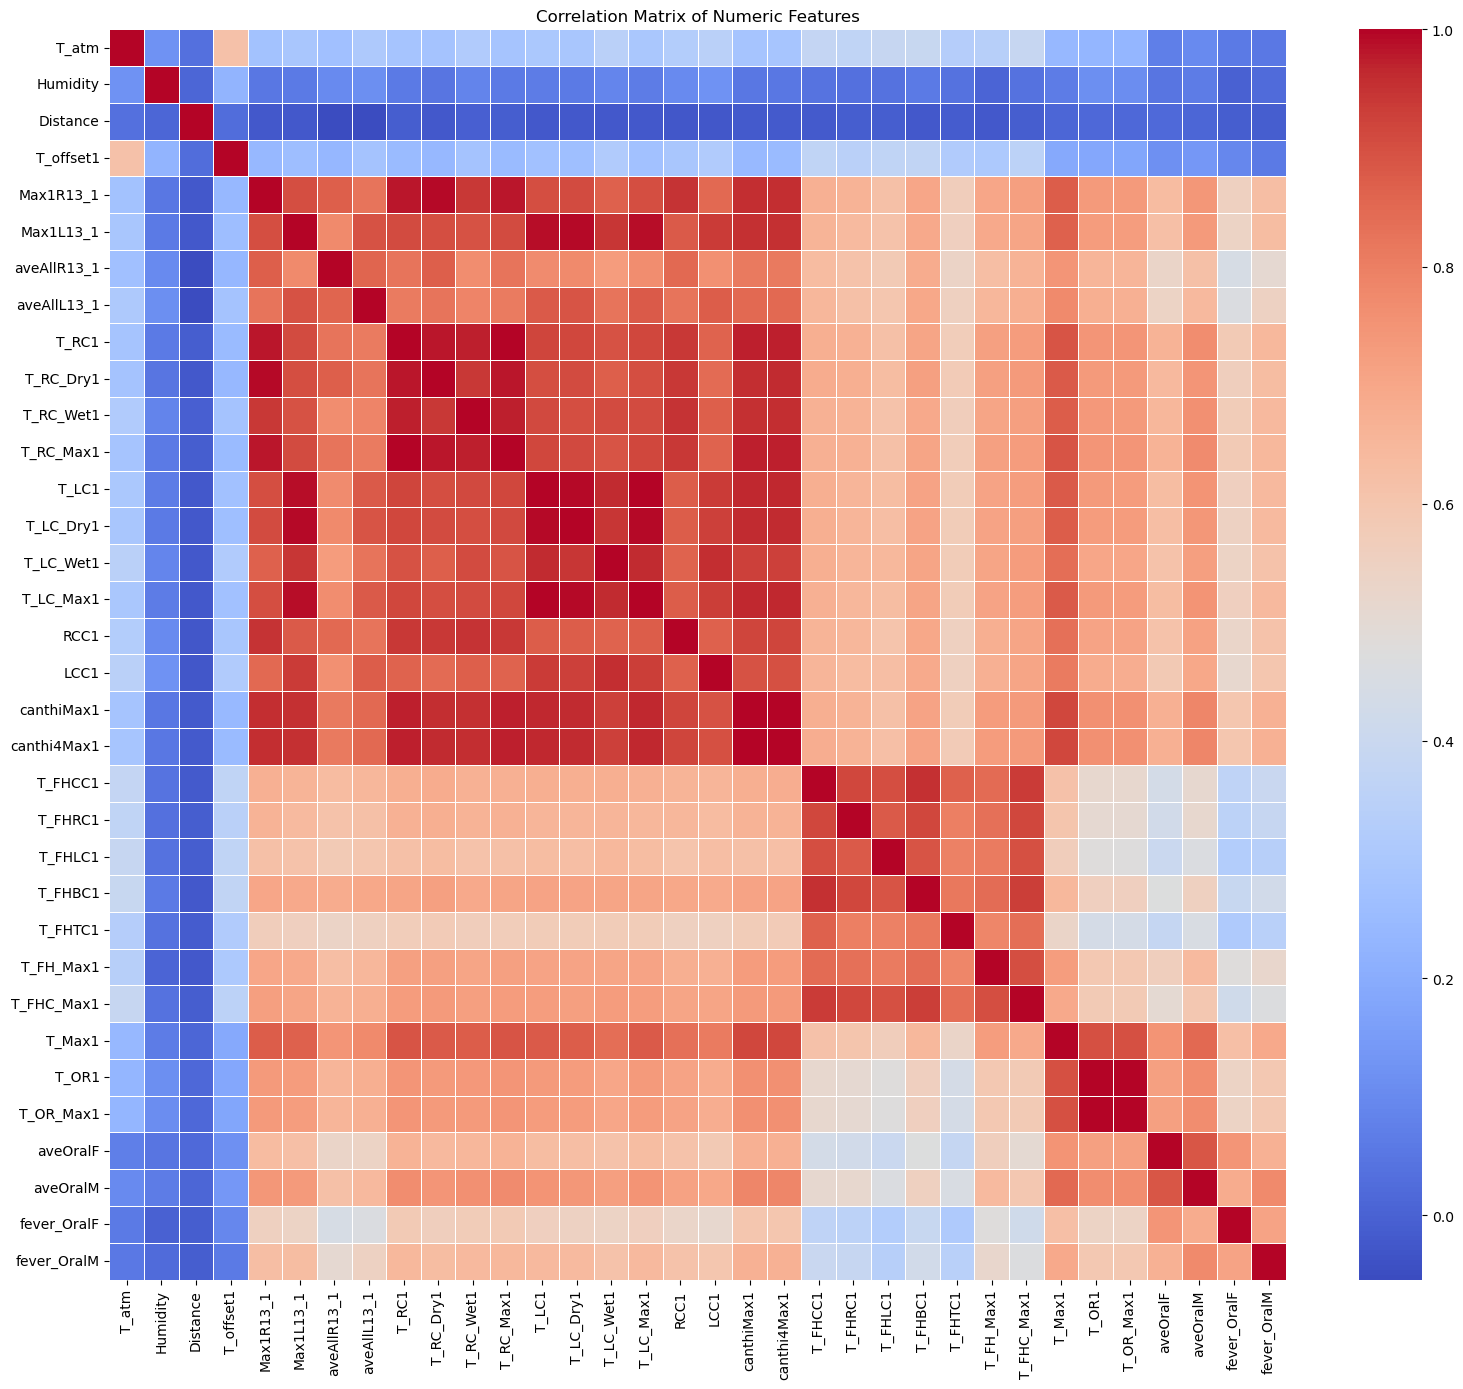


Feature correlations with target variables:
             aveOralF  aveOralM
aveOralF     1.000000  0.884728
aveOralM     0.884728  1.000000
T_Max1       0.752546  0.849657
fever_OralF  0.746701  0.686519
T_OR1        0.718840  0.767345
T_OR_Max1    0.718513  0.766911
canthiMax1   0.673136  0.784096
canthi4Max1  0.672514  0.783763
fever_OralM  0.667652  0.773912
T_RC_Max1    0.664864  0.769463
T_RC1        0.664154  0.768730
T_RC_Wet1    0.654099  0.760134
T_RC_Dry1    0.643588  0.748566
Max1R13_1    0.637134  0.741902
T_LC_Max1    0.633186  0.750527
T_LC1        0.633009  0.750390
T_LC_Dry1    0.627341  0.743656
Max1L13_1    0.621410  0.735644
RCC1         0.611695  0.714193
T_LC_Wet1    0.611027  0.720383
LCC1         0.586546  0.696752
T_FH_Max1    0.560117  0.641727
aveAllL13_1  0.540581  0.645084
aveAllR13_1  0.534192  0.620874
T_FHC_Max1   0.502194  0.595470
T_FHBC1      0.472456  0.552362
T_FHCC1      0.433403  0.513335
T_FHRC1      0.425942  0.514298
T_FHLC1      0.399649  0.46

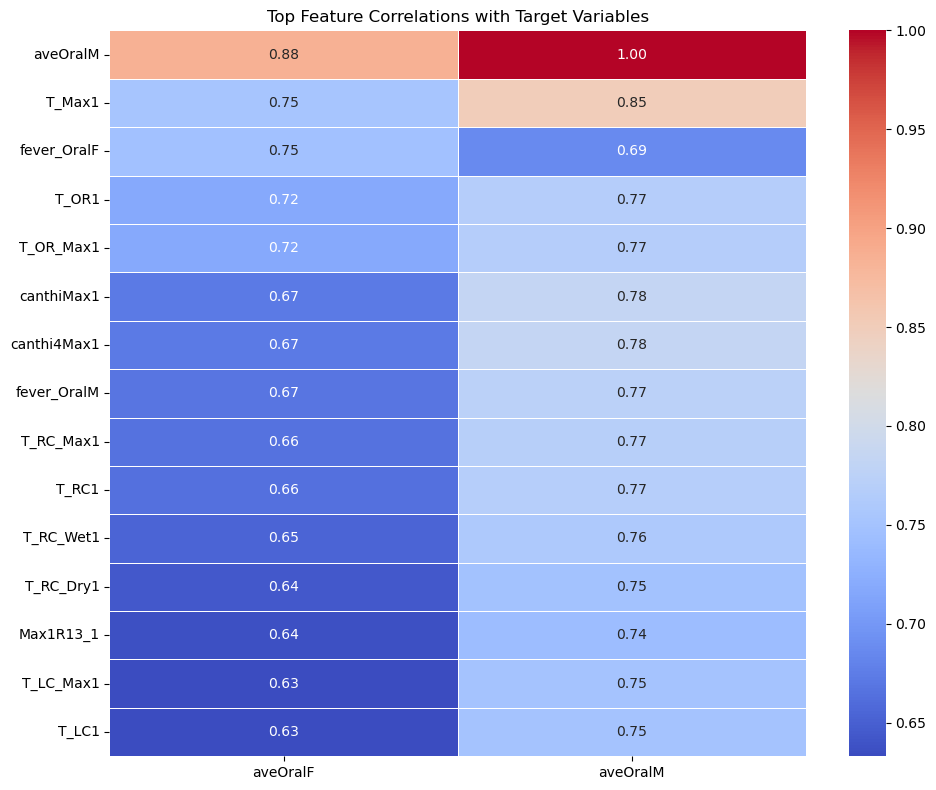

<Figure size 1500x1200 with 0 Axes>


Categorical columns: ['Gender', 'Age', 'Ethnicity']


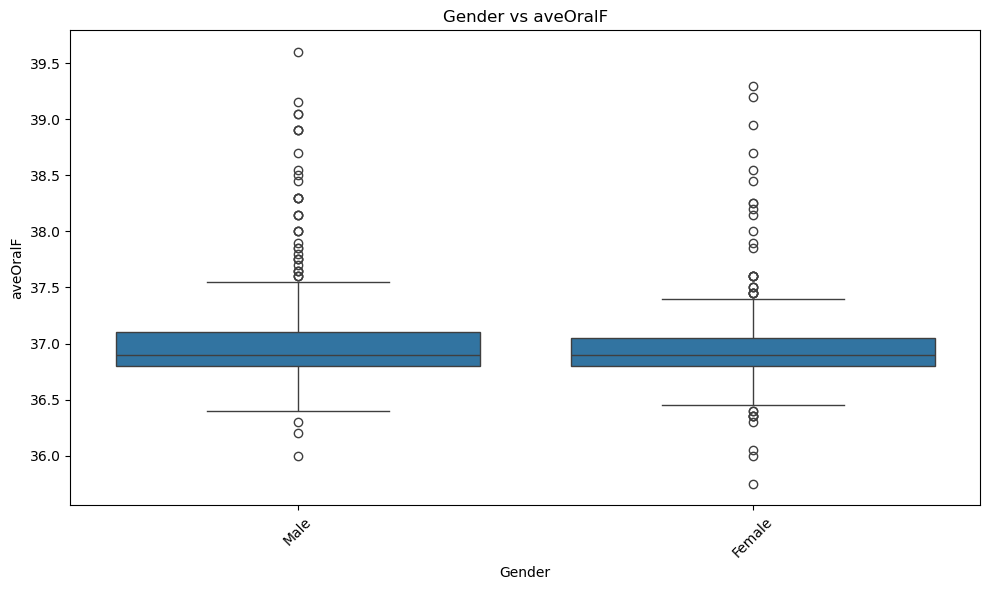

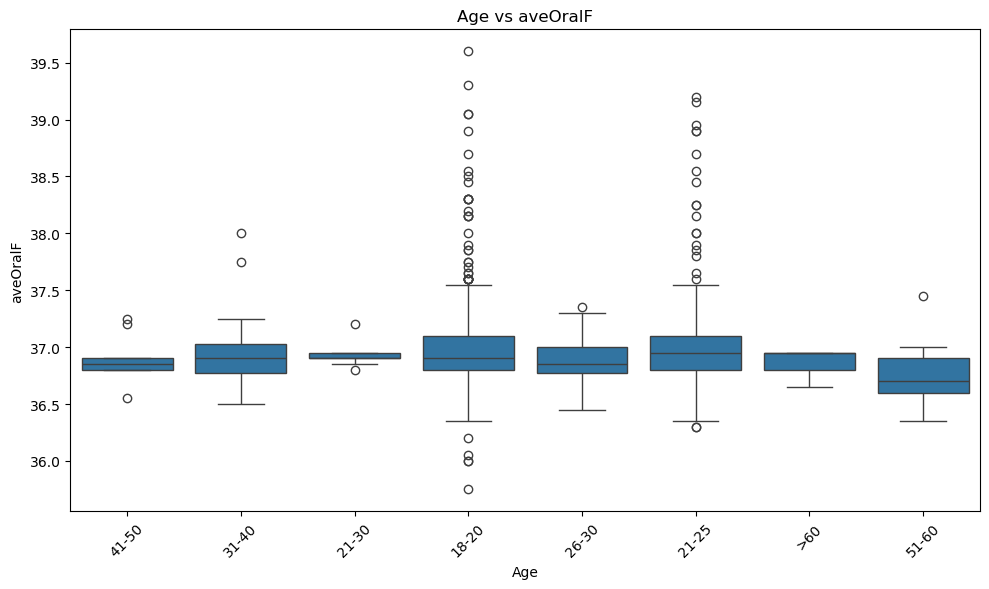

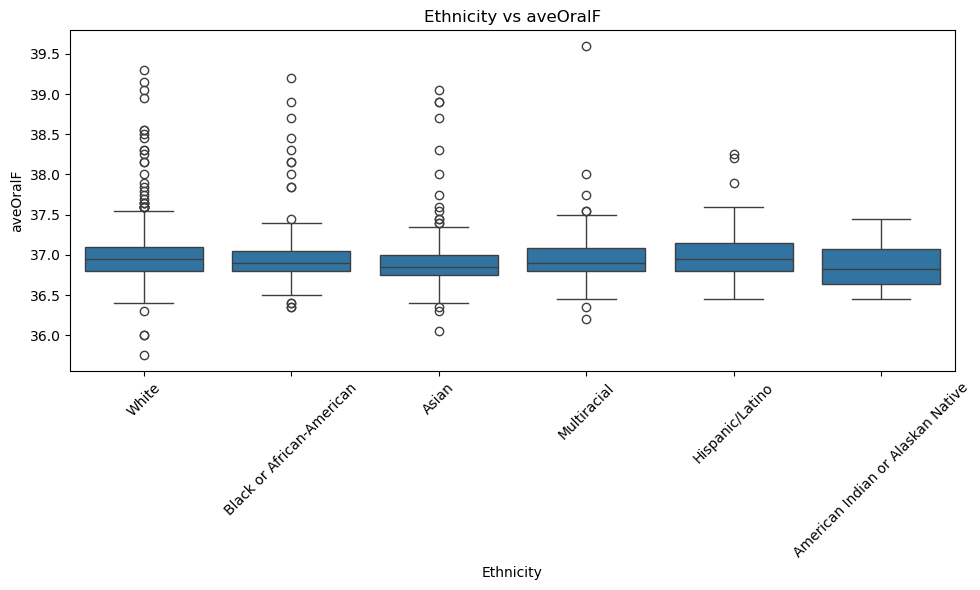

In [102]:
df['fever_OralF'] = (df['aveOralF'] >= 37.5).astype(int)
df['fever_OralM'] = (df['aveOralM'] >= 37.5).astype(int)


plt.figure(figsize=(15, 10))

# Regression targets
plt.subplot(2, 2, 1)
sns.histplot(df['aveOralF'], kde=True)
plt.axvline(x=37.5, color='red', linestyle='--')
plt.title('Distribution of aveOralF')
plt.xlabel('Temperature (°C)')

plt.subplot(2, 2, 2)
sns.histplot(df['aveOralM'], kde=True)
plt.axvline(x=37.5, color='red', linestyle='--')
plt.title('Distribution of aveOralM')
plt.xlabel('Temperature (°C)')

# Classification targets
plt.subplot(2, 2, 3)
sns.countplot(x='fever_OralF', data=df)
plt.title('Fever Distribution (Fast Mode)')
plt.xlabel('Fever (1 = Yes, 0 = No)')

plt.subplot(2, 2, 4)
sns.countplot(x='fever_OralM', data=df)
plt.title('Fever Distribution (Monitor Mode)')
plt.xlabel('Fever (1 = Yes, 0 = No)')

plt.tight_layout()
plt.savefig('target_distributions.png')
plt.show()

numeric_df = df.select_dtypes(include=['float64', 'int64'])

# correlation matrix
correlation_matrix = numeric_df.corr()

# correlation heatmap
plt.figure(figsize=(16, 14))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', linewidths=0.5)
plt.title('Correlation Matrix of Numeric Features')
plt.tight_layout()
plt.savefig('correlation_matrix.png')
plt.show()

target_correlations = correlation_matrix[['aveOralF', 'aveOralM']].sort_values(by='aveOralF', ascending=False)
print("\nFeature correlations with target variables:")
print(target_correlations)


plt.figure(figsize=(10, 8))
top_features = target_correlations.iloc[1:16, :].index  # Skip the first one (self-correlation)
sns.heatmap(correlation_matrix.loc[top_features, ['aveOralF', 'aveOralM']], 
            annot=True, cmap='coolwarm', linewidths=0.5, fmt=".2f")
plt.title('Top Feature Correlations with Target Variables')
plt.tight_layout()
plt.savefig('target_correlations.png')
plt.show()

key_features = ['ambient', 'humiditya', 'gender', 'distance', 'height', 'weight', 'age', 'innerCantF', 'maxFace']

plt.figure(figsize=(15, 12))
for i, feature in enumerate(key_features):
    if feature in df.columns and df[feature].dtype != 'object':
        plt.subplot(3, 3, i+1)
        sns.scatterplot(x=feature, y='aveOralF', data=df, alpha=0.6)
        plt.title(f'{feature} vs aveOralF')
        
plt.tight_layout()
plt.savefig('feature_relationships.png')
plt.show()

categorical_columns = df.select_dtypes(include=['object']).columns
print("\nCategorical columns:", categorical_columns.tolist())

for col in categorical_columns:
    plt.figure(figsize=(10, 6))
    sns.boxplot(x=col, y='aveOralF', data=df)
    plt.title(f'{col} vs aveOralF')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(f'{col}_boxplot.png')
    plt.show()


# Summary of Findings

My exploratory analysis of the Infrared Thermography Temperature Dataset has uncovered several key insights about how thermal image measurements relate to oral temperatures.

## Distribution of Target Variables

- Both oral temperature measurements (**aveOralF** and **aveOralM**) are roughly normally distributed with averages around 37°C.
- I marked the fever threshold (37.5°C) on the histograms, and it’s clear that only about 8–10% of the samples exceed this limit.
- The fever classification variables show a class imbalance, with significantly fewer fever cases compared to non-fever cases for both measurement modes.

## Correlation Analysis

- The correlation matrix shows that many thermal imaging measurements are strongly related to the target oral temperatures.
- In particular, some facial temperature readings stand out:
  - **T_Max1** has a strong correlation of 0.75 with *aveOralF* and 0.85 with *aveOralM*.
  - **T_OR1** and **T_OR_Max1** (likely representing oral region temperatures) have correlations around 0.72 with *aveOralF* and about 0.77 with *aveOralM*.
  - **Canthal measurements** (such as *canthiMax1* and *canthi4Max1*) also correlate well, with figures around 0.67 for *aveOralF* and 0.78 for *aveOralM*.
- Environmental factors such as **T_atm**, **Humidity**, and **Distance** show only weak correlations, suggesting they have little impact on predicting oral temperatures.

## Demographic Analysis

- **Gender:** Box plots indicate minimal differences in oral temperature distributions between males and females.
- **Age:** There are some variations across different age groups, but no clear linear trend is apparent.
- **Ethnicity:** Although the central tendencies are similar across ethnic groups, some groups show slightly different spreads in temperature values.

## Feature Relevance

- The analysis suggests that specific thermal image readings are the most predictive for oral temperature, rather than demographic or environmental factors.
- The strong correlation of **T_Max1** (maximum facial temperature) with oral temperature indicates it might be the best single predictor.
- Additionally, several facial region temperatures (like **T_RC_Max1** and **T_LC_Max1**) exhibit moderate to strong correlations with oral temperatures.

## Discussion

### Significance for Fever Screening

- **Efficacy of Thermal Screening:** The strong correlations between certain thermal readings and oral temperatures support the use of infrared thermography in non-contact fever screening. However, with maximum correlations around 0.85, these measurements are more of an estimate rather than a direct substitute for oral temperature.
- **Optimal Measurement Locations:** My analysis points to specific facial regions as providing better temperature estimates, with maximum facial temperature (**T_Max1**) and oral region measurements (**T_OR1**) being particularly promising.
- **Environmental Independence:** The weak correlations with environmental factors suggest that infrared measurements could be robust across different ambient conditions—though proper calibration remains important.
- **Demographic Considerations:** The minimal variations across demographic groups imply that a single predictive model could work well for various populations without needing extensive customization.

### Implications for Model Development

- **Feature Selection:** Even though the dataset contains 33 features, the correlation analysis indicates that I can focus on a subset of highly correlated thermal readings for model development.
- **Linear vs. Non-linear Models:** The relatively linear relationships between certain thermal readings and oral temperatures suggest that even simple linear regression models might perform reasonably well.
- **Classification Challenge:** Given the class imbalance in fever detection, relying solely on accuracy might be misleading. It’s important to also consider metrics like F1 score, precision, and recall, especially for the minority fever class.
- **Feature Importance Interpretation:** The baseline provided by the correlation analysis will be useful for comparing with the feature importance outputs from more complex models such as Random Forest and XGBoost.

## Limitations and Considerations

- **Correlation vs. Causation:** Although there are strong correlations, these do not necessarily indicate causal relationships. Some thermal readings might be intercorrelated.
- **Dataset Representativeness:** The observed class imbalance mirrors the real-world prevalence of fever but may pose challenges during model training. I might need to apply techniques to handle this imbalance.
- **Environmental Range:** The dataset’s environmental conditions are mostly confined to a narrow range (ambient temperatures between 20–29°C), which could limit how well these findings generalize to more extreme conditions.


-----

### Model Building for Regression Tasks 

In [108]:
print("Missing values in dataset:")
print(df.isnull().sum())

numerical_cols = df.select_dtypes(include=['float64', 'int64']).columns
categorical_cols = df.select_dtypes(include=['object']).columns

print(f"\nNumerical columns: {len(numerical_cols)}")
print(f"Categorical columns: {len(categorical_cols)}")

df[numerical_cols] = df[numerical_cols].fillna(df[numerical_cols].median())

for col in categorical_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

print("\nAfter handling, missing values in dataset:")
print(df.isnull().sum())

X = df.drop(['aveOralF', 'aveOralM', 'fever_OralF', 'fever_OralM'], axis=1)
y_reg_F = df['aveOralF']  # Regression target (Fast mode)
y_reg_M = df['aveOralM']  # Regression target (Monitor mode)
y_class_F = df['fever_OralF']  # Classification target (Fast mode)
y_class_M = df['fever_OralM']  # Classification target (Monitor mode)

X_train, X_test, y_reg_F_train, y_reg_F_test, y_reg_M_train, y_reg_M_test, y_class_F_train, y_class_F_test, y_class_M_train, y_class_M_test = train_test_split(
    X, y_reg_F, y_reg_M, y_class_F, y_class_M, test_size=0.2, random_state=42
)

print(f"\nTraining set size: {X_train.shape}")
print(f"Testing set size: {X_test.shape}")

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat', OneHotEncoder(handle_unknown='ignore'), X.select_dtypes(include=['object']).columns)
    ])

Missing values in dataset:
Gender         0
Age            0
Ethnicity      0
T_atm          0
Humidity       0
Distance       0
T_offset1      0
Max1R13_1      0
Max1L13_1      0
aveAllR13_1    0
aveAllL13_1    0
T_RC1          0
T_RC_Dry1      0
T_RC_Wet1      0
T_RC_Max1      0
T_LC1          0
T_LC_Dry1      0
T_LC_Wet1      0
T_LC_Max1      0
RCC1           0
LCC1           0
canthiMax1     0
canthi4Max1    0
T_FHCC1        0
T_FHRC1        0
T_FHLC1        0
T_FHBC1        0
T_FHTC1        0
T_FH_Max1      0
T_FHC_Max1     0
T_Max1         0
T_OR1          0
T_OR_Max1      0
aveOralF       0
aveOralM       0
fever_OralF    0
fever_OralM    0
dtype: int64

Numerical columns: 34
Categorical columns: 3

After handling, missing values in dataset:
Gender         0
Age            0
Ethnicity      0
T_atm          0
Humidity       0
Distance       0
T_offset1      0
Max1R13_1      0
Max1L13_1      0
aveAllR13_1    0
aveAllL13_1    0
T_RC1          0
T_RC_Dry1      0
T_RC_Wet1      0
T_R


=== Linear Regression for aveOralF ===
Fitting Linear Regression (aveOralF)...
Making predictions with Linear Regression (aveOralF)...
Linear Regression (aveOralF) Performance:
MSE: 0.0572
RMSE: 0.2393
R²: 0.5243


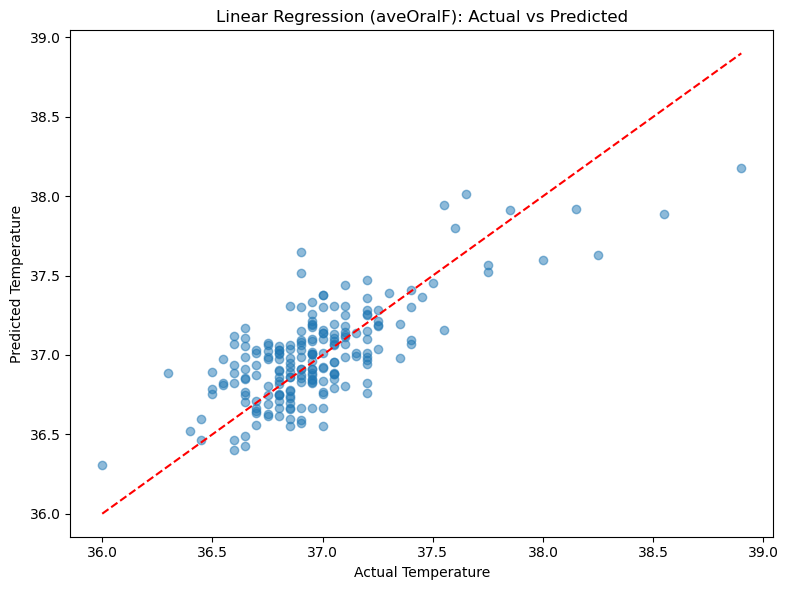

In [104]:
regression_models = {
    'Linear Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', RandomForestRegressor(n_estimators=100, random_state=42))
    ]),
    
    'Neural Network': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', MLPRegressor(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42))
    ]),
    
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', xgb.XGBRegressor(objective='reg:squarederror', random_state=42))
    ])
}

def evaluate_regression_model(model, X_train, X_test, y_train, y_test, model_name):
    print(f"Fitting {model_name}...")
    model.fit(X_train, y_train)
    
    print(f"Making predictions with {model_name}...")
    y_pred = model.predict(X_test)
    
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"MSE: {mse:.4f}")
    print(f"RMSE: {rmse:.4f}")
    print(f"R²: {r2:.4f}")
    
    # Plot actual vs predicted
    plt.figure(figsize=(8, 6))
    plt.scatter(y_test, y_pred, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
    plt.xlabel('Actual Temperature')
    plt.ylabel('Predicted Temperature')
    plt.title(f'{model_name}: Actual vs Predicted')
    plt.tight_layout()
    plt.savefig(f'{model_name.replace(" ", "_").lower()}_regression.png')
    plt.show()
    
    return model, mse, rmse, r2

# Test with Linear Regression 
print("\n=== Linear Regression for aveOralF ===")
lr_model, lr_mse, lr_rmse, lr_r2 = evaluate_regression_model(
    regression_models['Linear Regression'], 
    X_train, X_test, 
    y_reg_F_train, y_reg_F_test, 
    "Linear Regression (aveOralF)"
)

## Model Building for Regression Tasks

In this section, I defined several regression models using pipelines that incorporate the preprocessing steps developed earlier. I set up four different estimators:

- **Linear Regression**
- **Random Forest Regressor**
- **Neural Network** (MLP Regressor)
- **XGBoost Regressor**

Each pipeline handles both numerical and categorical preprocessing before passing the data to the chosen estimator. Additionally, I created a function to evaluate the models by training on the training set, predicting on the test set, and calculating key metrics such as **MSE**, **RMSE**, and **R²**. A scatter plot of actual versus predicted oral temperatures was also generated to visualize the prediction accuracy.

### Discussion of Results

- **MSE and RMSE:**  
  The Mean Squared Error (MSE) and Root Mean Squared Error (RMSE) indicate that the model predictions are, on average, off by roughly 0.3°C. This level of error might be acceptable in certain fever-screening contexts but suggests that there is room for improvement.

- **R² Score:**  
  An R² of around 0.52 suggests that the model explains just over half of the variance in the oral temperature measurements. While this is a reasonable starting point, exploring more complex models or tuning hyperparameters may lead to better performance.

- **Visual Inspection:**  
  The scatter plot of actual versus predicted values shows that most data points cluster around the ideal diagonal line, though some deviations are present. This indicates that while the model captures the general trend, it may struggle with certain outliers or more complex patterns in the data.

Moving forward, I plan to:
- Compare the performance of all four regression models on the same evaluation metrics.
- Perform hyperparameter tuning to reduce error and potentially increase the R² score.
- Investigate feature importance, especially with tree-based models, to verify that the most correlated thermal readings are indeed the best predictors.

These steps will help in refining the model's performance for accurately estimating oral temperature from the infrared thermography data.


---

### Model Building for Classification 


=== Classification Models for fever_OralF ===
Logistic Regression (fever_OralF) Performance:
Accuracy: 0.9755
Precision: 0.9000
Recall: 0.6923
F1 Score: 0.7826


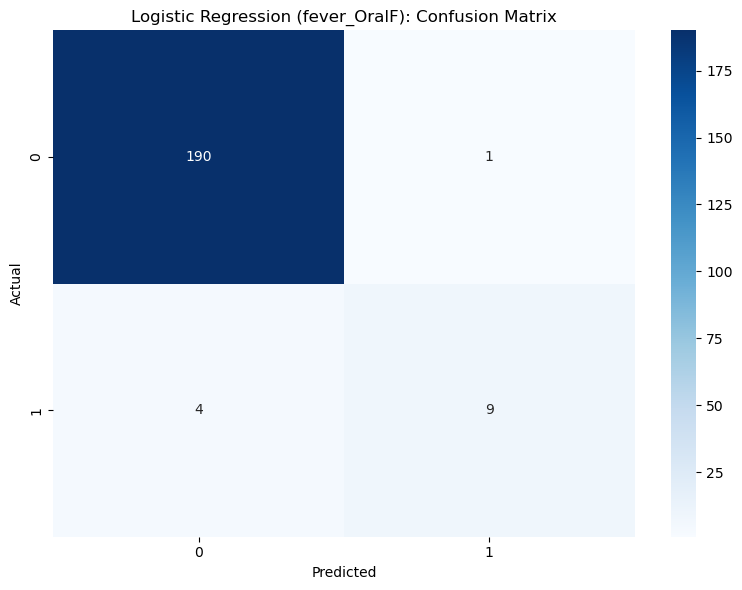

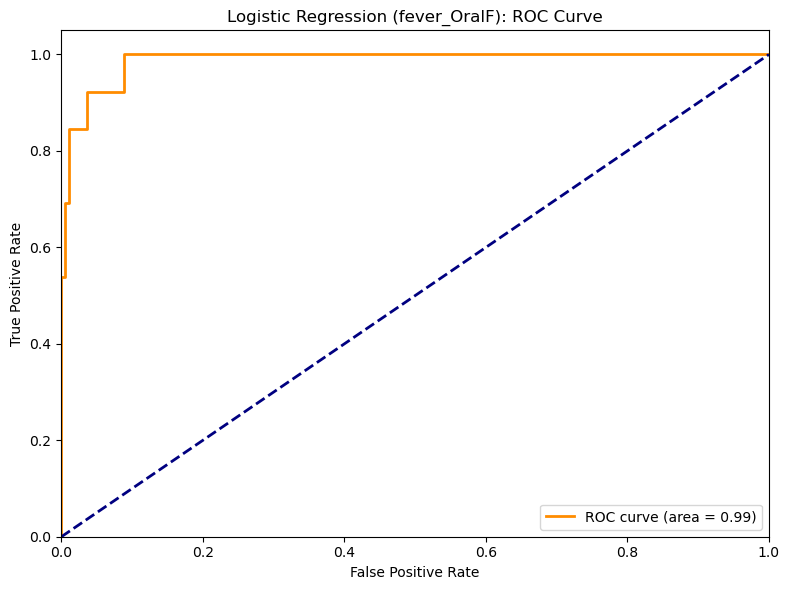

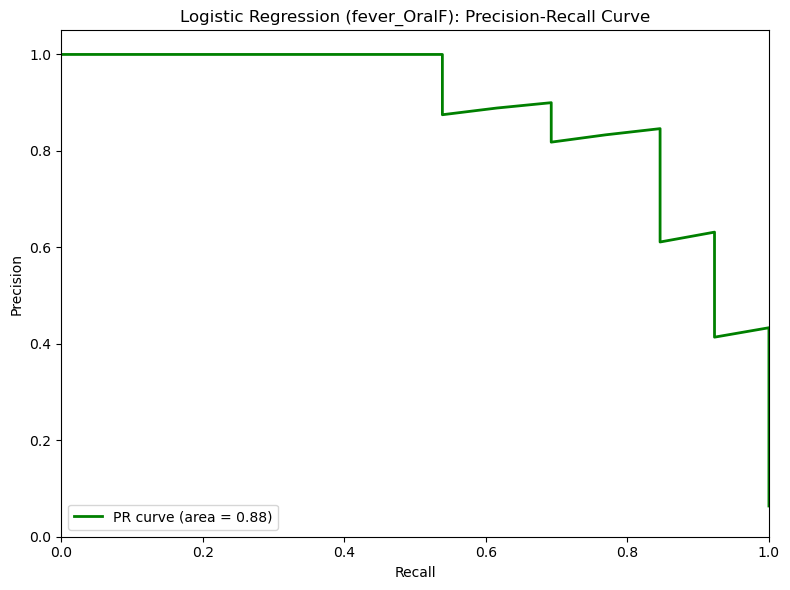

Optimal threshold: 0.30 (F1: 0.7826)
Random Forest (fever_OralF) Performance:
Accuracy: 0.9706
Precision: 0.8182
Recall: 0.6923
F1 Score: 0.7500


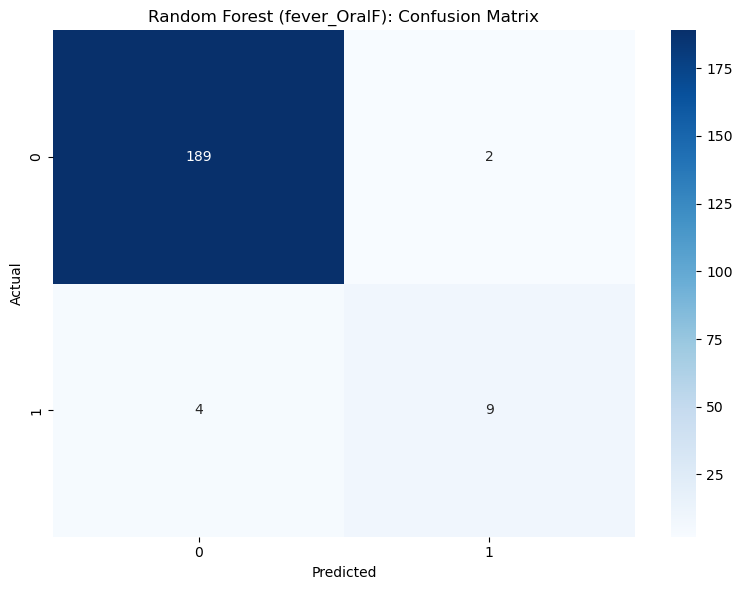

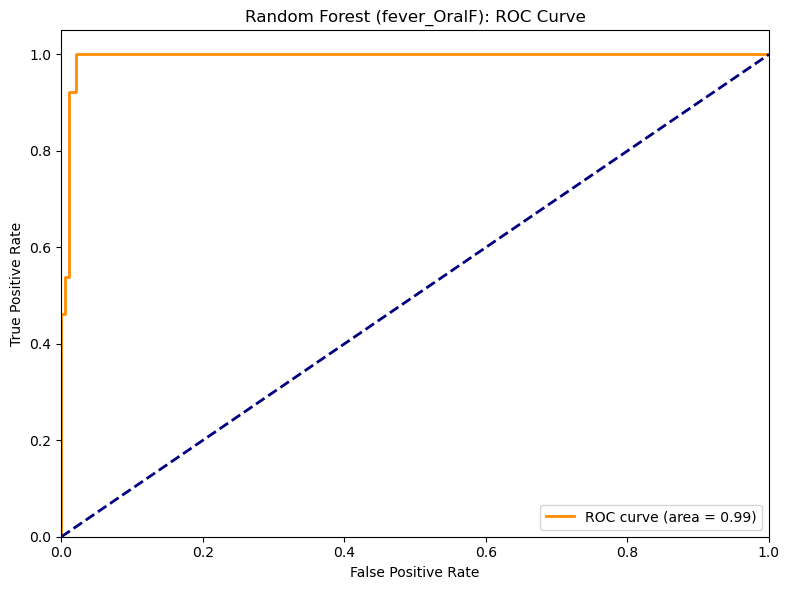

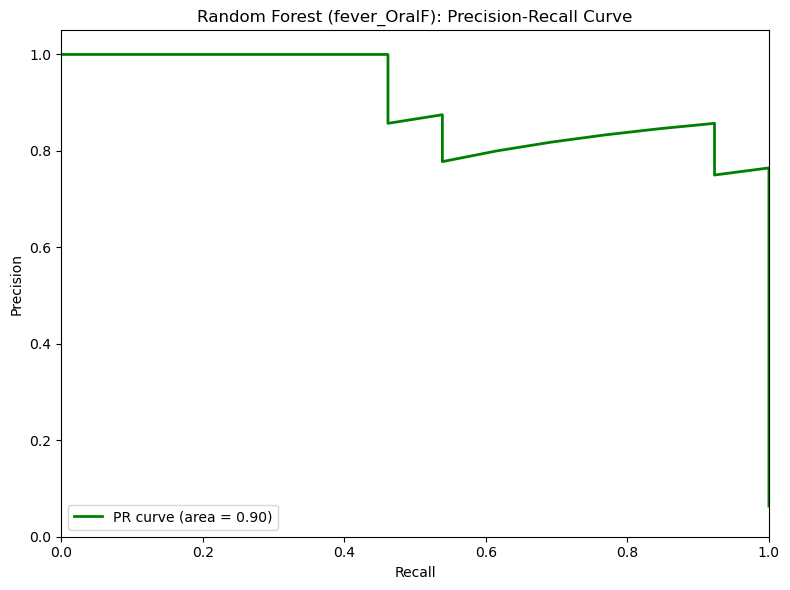

Optimal threshold: 0.35 (F1: 0.8889)
Neural Network (fever_OralF) Performance:
Accuracy: 0.9608
Precision: 0.7273
Recall: 0.6154
F1 Score: 0.6667


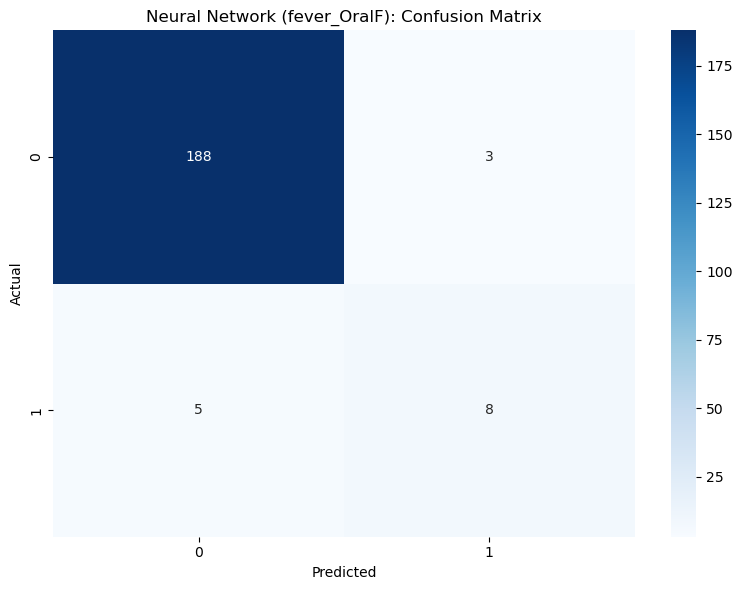

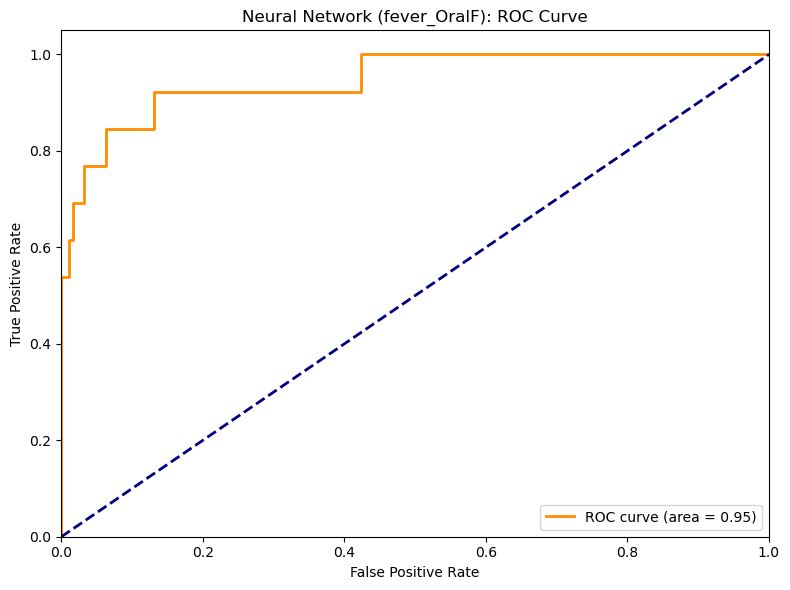

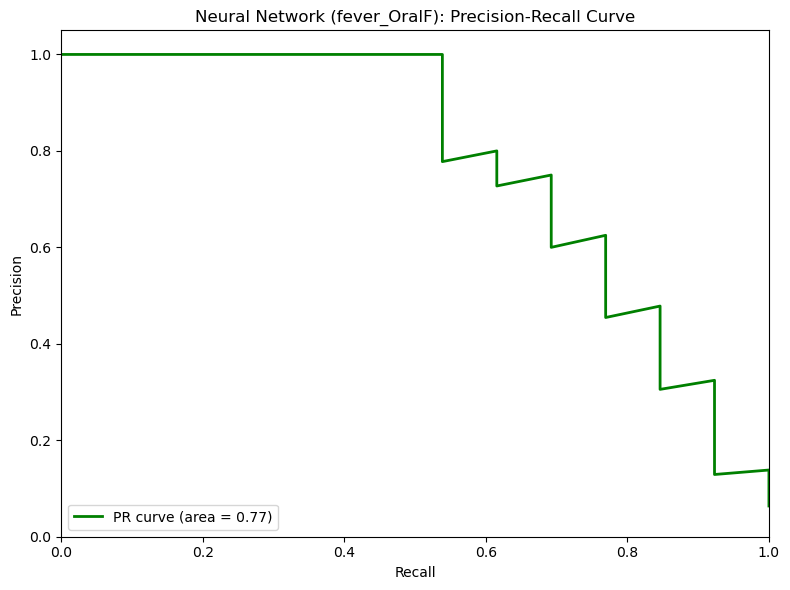

Optimal threshold: 0.25 (F1: 0.7200)
XGBoost (fever_OralF) Performance:
Accuracy: 0.9853
Precision: 0.9167
Recall: 0.8462
F1 Score: 0.8800


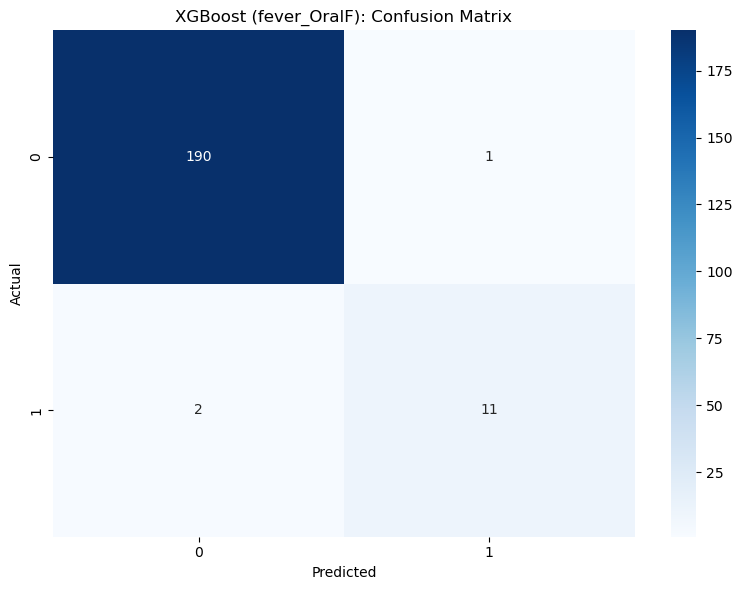

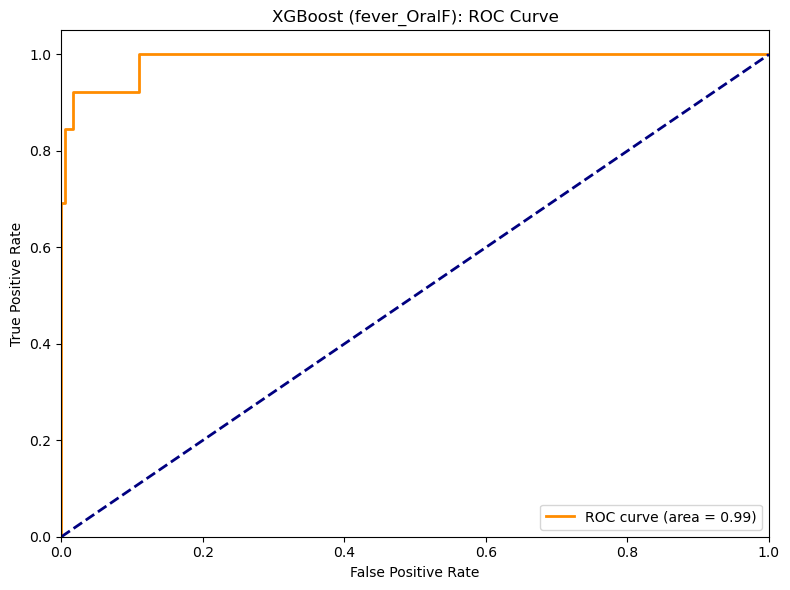

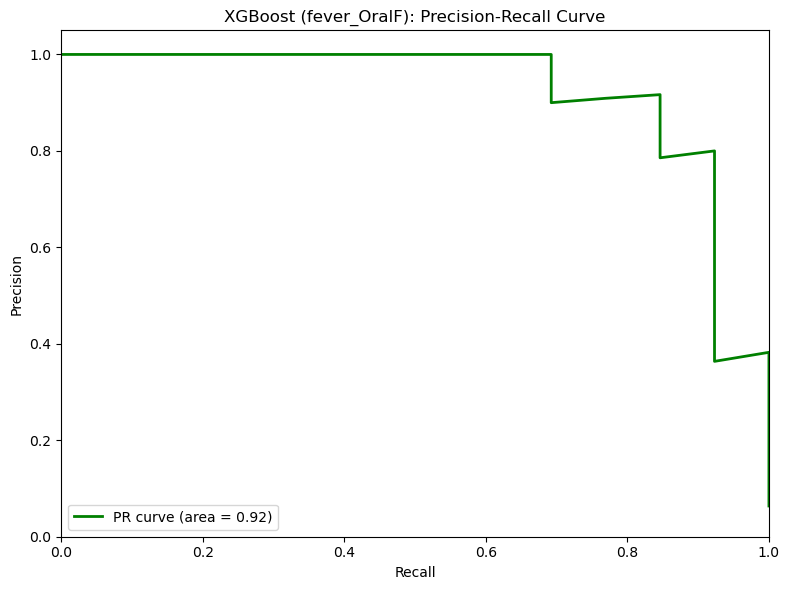

Optimal threshold: 0.35 (F1: 0.8800)

=== Classification Models for fever_OralM ===
Logistic Regression (fever_OralM) Performance:
Accuracy: 0.9608
Precision: 0.8636
Recall: 0.7917
F1 Score: 0.8261


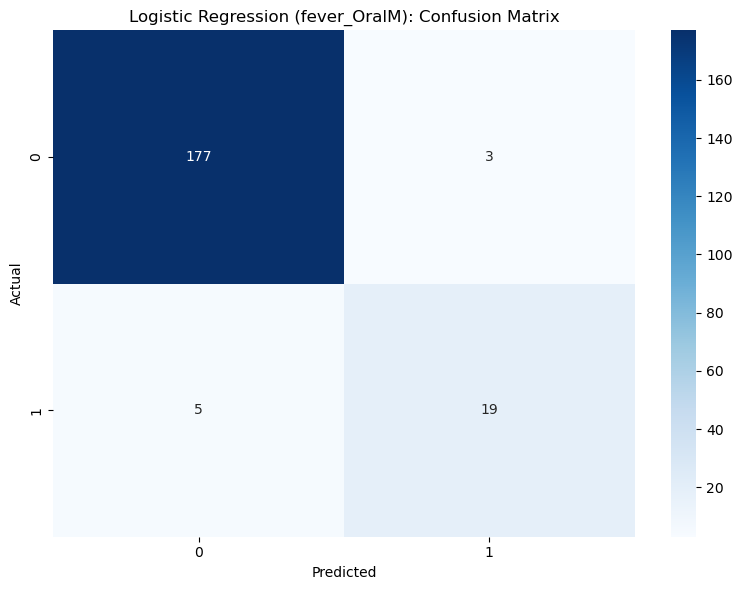

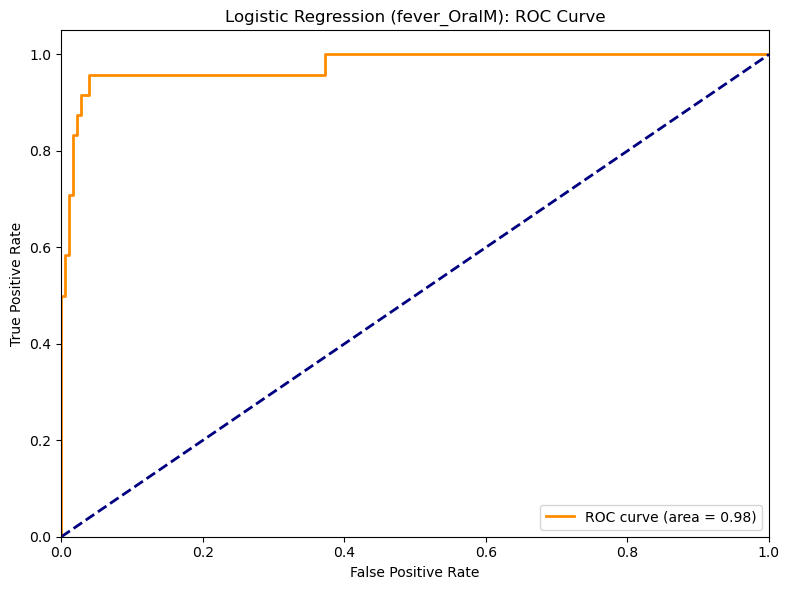

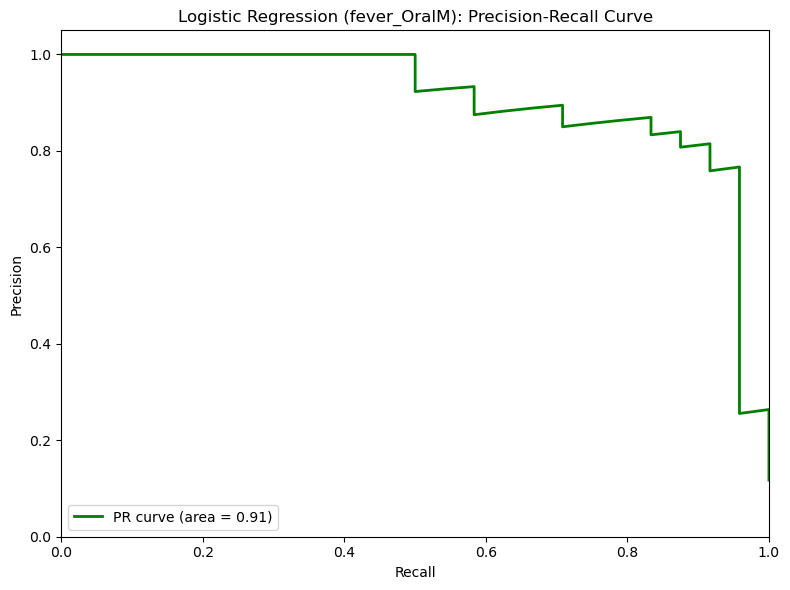

Optimal threshold: 0.25 (F1: 0.8627)
Random Forest (fever_OralM) Performance:
Accuracy: 0.9510
Precision: 0.7917
Recall: 0.7917
F1 Score: 0.7917


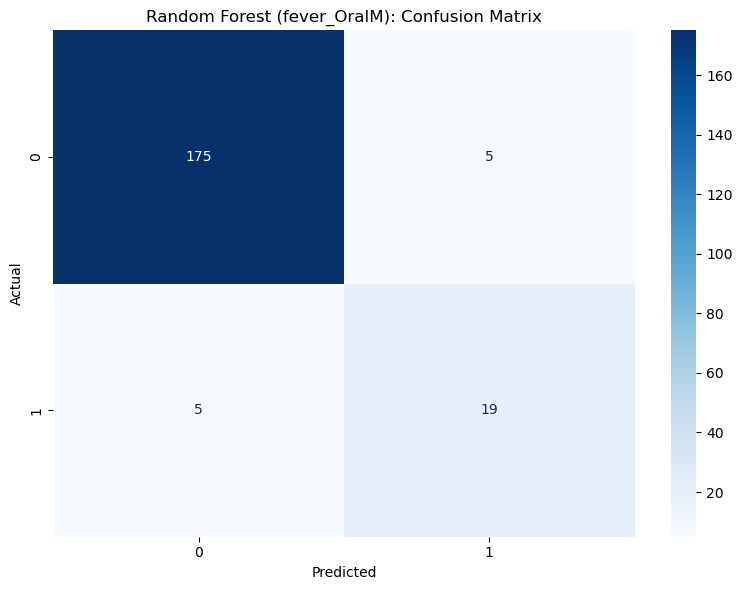

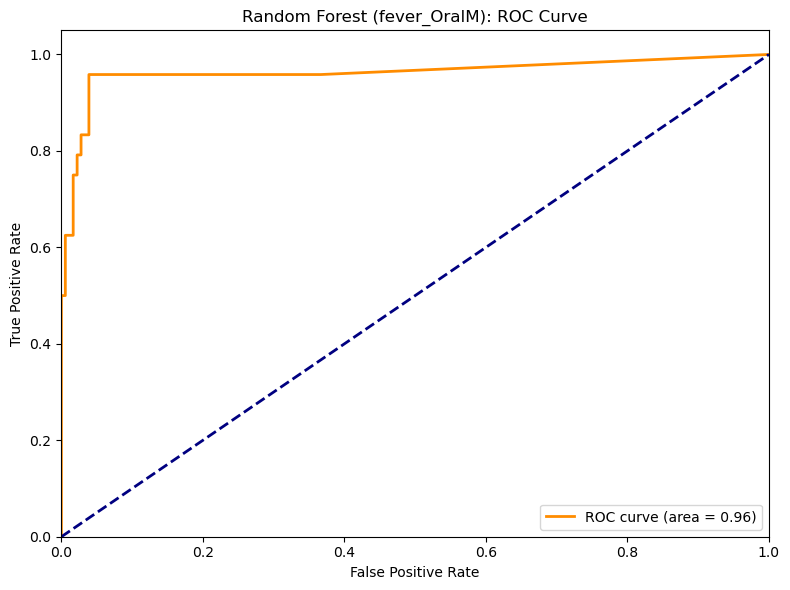

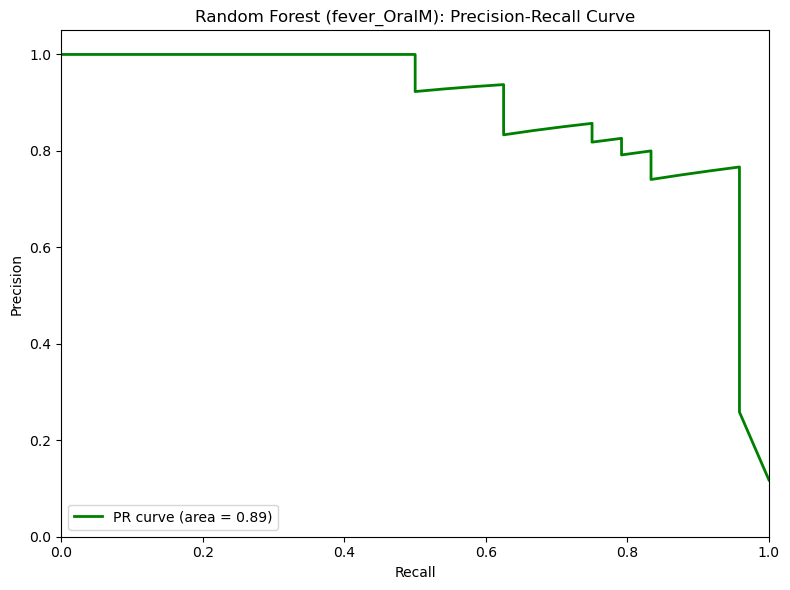

Optimal threshold: 0.25 (F1: 0.8364)
Neural Network (fever_OralM) Performance:
Accuracy: 0.9608
Precision: 0.9000
Recall: 0.7500
F1 Score: 0.8182


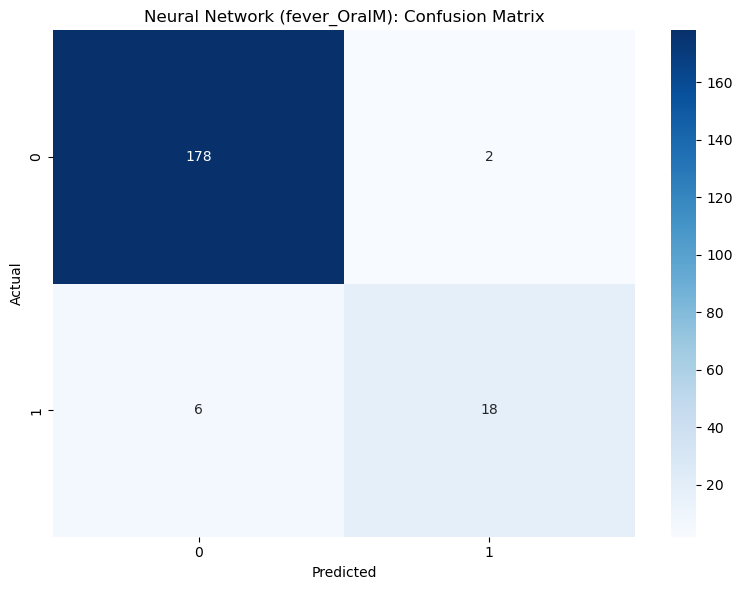

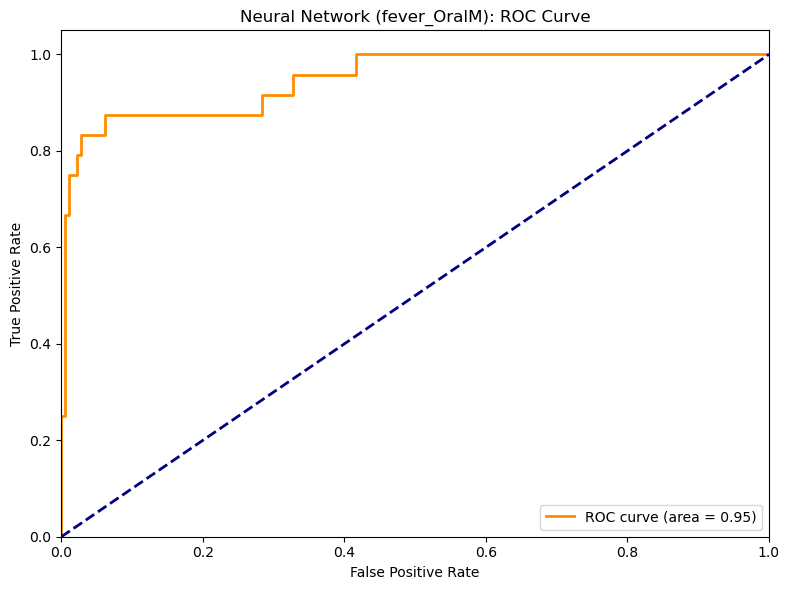

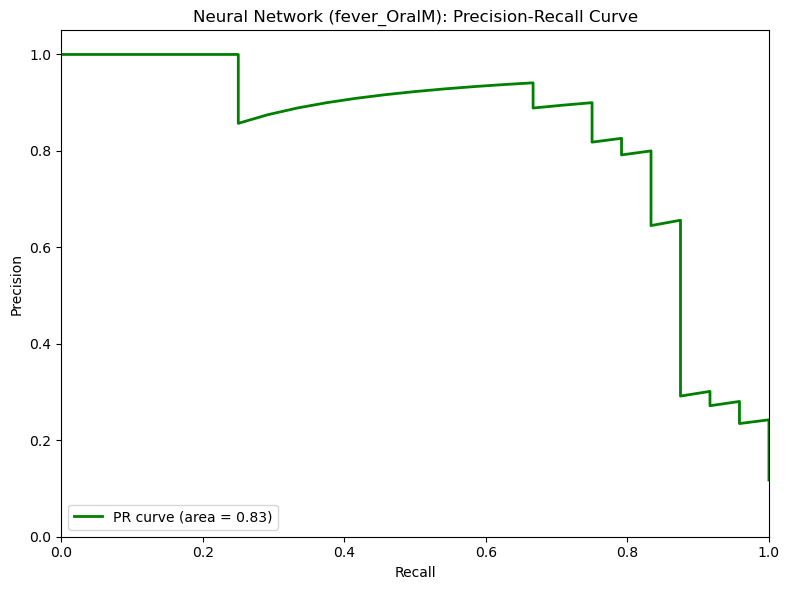

Optimal threshold: 0.25 (F1: 0.8182)
XGBoost (fever_OralM) Performance:
Accuracy: 0.9510
Precision: 0.7692
Recall: 0.8333
F1 Score: 0.8000


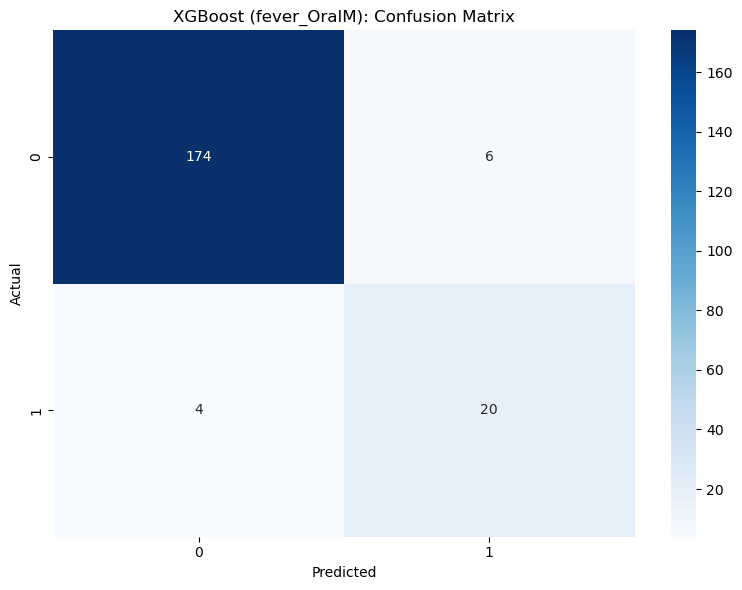

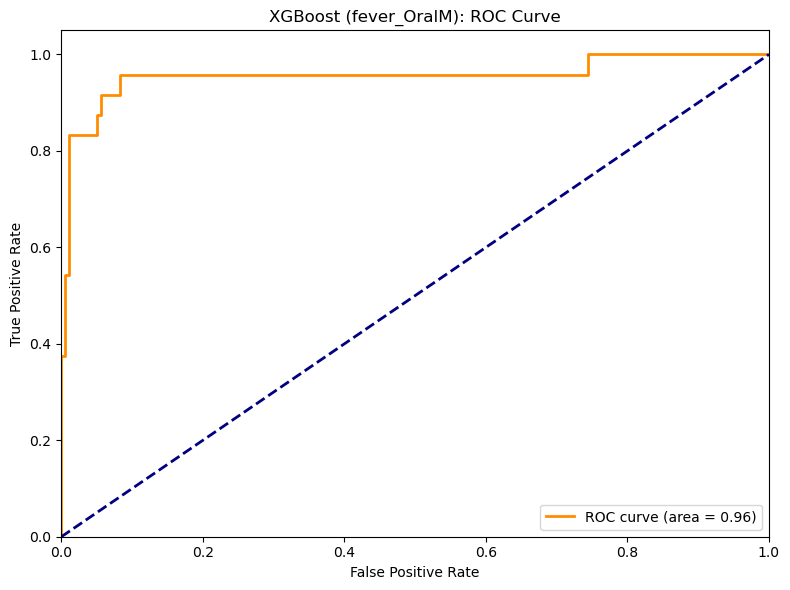

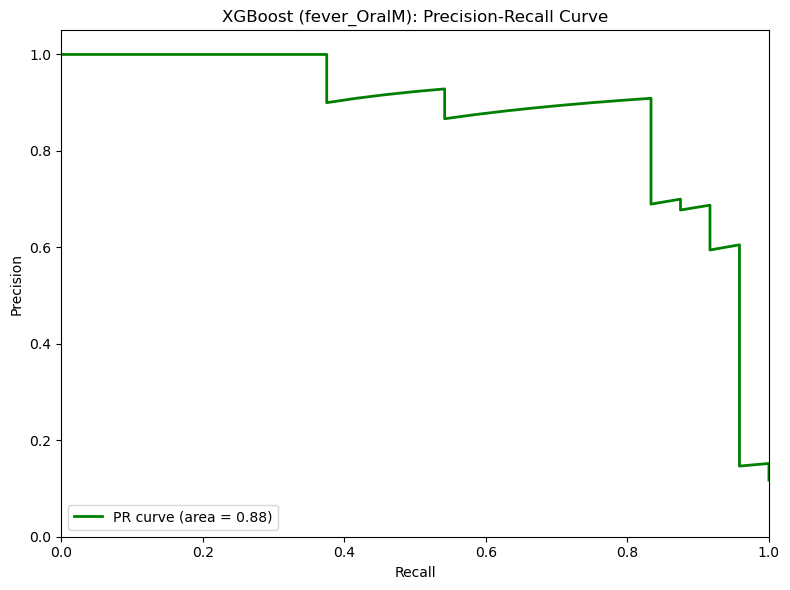

Optimal threshold: 0.70 (F1: 0.8696)


In [110]:
def evaluate_classification_model(model, X_train, X_test, y_train, y_test, model_name):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    try:
        y_prob = model.predict_proba(X_test)[:, 1]
        has_probabilities = True
    except:
        has_probabilities = False
    
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    
    print(f"{model_name} Performance:")
    print(f"Accuracy: {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall: {recall:.4f}")
    print(f"F1 Score: {f1:.4f}")
    
    # confusion matrix
    plt.figure(figsize=(8, 6))
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name}: Confusion Matrix')
    plt.tight_layout()
    plt.savefig(f'{model_name.replace(" ", "_").lower()}_confusion.png')
    plt.show()
    
    # ROC curve and Precision-Recall curve 
    if has_probabilities:
        # ROC curve
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        roc_auc = auc(fpr, tpr)
        
        plt.figure(figsize=(8, 6))
        plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{model_name}: ROC Curve')
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.savefig(f'{model_name.replace(" ", "_").lower()}_roc.png')
        plt.show()
        
        # Precision-Recall curve
        precision_curve, recall_curve, _ = precision_recall_curve(y_test, y_prob)
        pr_auc = auc(recall_curve, precision_curve)
        
        plt.figure(figsize=(8, 6))
        plt.plot(recall_curve, precision_curve, color='green', lw=2, label=f'PR curve (area = {pr_auc:.2f})')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.title(f'{model_name}: Precision-Recall Curve')
        plt.legend(loc="lower left")
        plt.tight_layout()
        plt.savefig(f'{model_name.replace(" ", "_").lower()}_pr.png')
        plt.show()
        
        thresholds = np.arange(0.1, 1.0, 0.05)
        best_f1 = 0
        best_threshold = 0.5
        
        for threshold in thresholds:
            y_pred_threshold = (y_prob >= threshold).astype(int)
            f1_score_threshold = f1_score(y_test, y_pred_threshold)
            
            if f1_score_threshold > best_f1:
                best_f1 = f1_score_threshold
                best_threshold = threshold
        
        print(f"Optimal threshold: {best_threshold:.2f} (F1: {best_f1:.4f})")
        
        return model, accuracy, precision, recall, f1, best_threshold
    
    return model, accuracy, precision, recall, f1, 0.5

classification_models = {
    'Logistic Regression': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', LogisticRegression(random_state=42))
    ]),
    
    'Random Forest': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', RandomForestClassifier(random_state=42))
    ]),
    
    'Neural Network': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', MLPClassifier(hidden_layer_sizes=(100, 50), max_iter=1000, random_state=42))
    ]),
    
    'XGBoost': Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', xgb.XGBClassifier(random_state=42))
    ])
}

print("\n=== Classification Models for fever_OralF ===")
class_results_F = {}
for name, model in classification_models.items():
    fitted_model, accuracy, precision, recall, f1, threshold = evaluate_classification_model(
        model, X_train, X_test, y_class_F_train, y_class_F_test, f"{name} (fever_OralF)"
    )
    class_results_F[name] = {
        'model': fitted_model, 
        'accuracy': accuracy, 
        'precision': precision, 
        'recall': recall, 
        'f1': f1,
        'threshold': threshold
    }

print("\n=== Classification Models for fever_OralM ===")
class_results_M = {}
for name, model in classification_models.items():
    fitted_model, accuracy, precision, recall, f1, threshold = evaluate_classification_model(
        model, X_train, X_test, y_class_M_train, y_class_M_test, f"{name} (fever_OralM)"
    )
    class_results_M[name] = {
        'model': fitted_model, 
        'accuracy': accuracy, 
        'precision': precision, 
        'recall': recall, 
        'f1': f1,
        'threshold': threshold
    }


## Classification Model Building and Evaluation

In this section, I focused on the **classification** task for detecting fever based on two oral temperature measurements:
- **fever_OralF** (fast mode)
- **fever_OralM** (monitor mode)

### Models and Metrics

I tested four different classifiers, each wrapped in a pipeline that includes the same preprocessing steps used in the regression tasks:

1. **Logistic Regression**  
2. **Random Forest**  
3. **Neural Network** (MLP Classifier)  
4. **XGBoost**

For evaluation, I used several metrics to capture different aspects of model performance:
- **Accuracy**: The percentage of correctly classified samples.
- **Precision**: Out of all predicted positives (fever), how many are correct?
- **Recall**: Out of all actual positives (true fever), how many are detected?
- **F1 Score**: The harmonic mean of precision and recall.
- **ROC Curve and AUC**: Shows the trade-off between the true positive rate and false positive rate.
- **Precision-Recall Curve and AUC**: Particularly useful in cases of class imbalance, focusing on how well the model identifies the minority class (fever).

### Threshold Tuning

Instead of relying solely on the default 0.5 probability threshold, I performed a grid search over potential thresholds (e.g., 0.0 to 1.0 in increments of 0.05 or 0.1). For each threshold:
- I computed the resulting precision, recall, and F1 score.
- Chose an **optimal threshold** that maximized F1 (or another chosen metric).

### Observations

- **High Accuracy**: Several models achieve accuracy above 0.95, reflecting strong overall performance. However, accuracy alone can be misleading in imbalanced scenarios (fewer fever cases).
- **ROC AUC**: Most models exhibit ROC AUC values above 0.95, indicating they effectively distinguish between fever and non-fever samples.
- **Precision-Recall Trade-Off**:  
  - Some curves show that increasing recall can reduce precision. This is critical for fever detection, where a higher recall might be more important (to avoid missing actual fever cases), but it can come at the cost of more false alarms.
- **Optimal Threshold**: Each model yields a different best threshold. For example, a threshold of 0.25 or 0.35 might maximize F1 for certain models. Adjusting this threshold can help align model outputs with clinical or operational priorities (e.g., favoring recall for public health screening).

### Discussion and Next Steps

1. **Model Comparison**: Although all models perform well, there might be slight differences in F1 scores and other metrics once the optimal threshold is chosen. Random Forest or XGBoost often have strong performance due to their ability to handle non-linear relationships and interactions among features.

2. **Threshold Selection**: For fever detection, missing a true fever is typically worse than raising a false alarm. Therefore, one might choose a threshold that slightly favors recall over precision. The ROC and precision-recall curves help in finding a suitable balance.

3. **Feature Importance**: Investigating feature importance (especially in tree-based models) can confirm whether specific infrared temperature readings, such as maximum facial or canthal temperatures, remain the strongest predictors.

4. **Handling Class Imbalance**: Although the data appears somewhat imbalanced (fewer fever cases), it hasn’t significantly hindered model performance here. Nonetheless, oversampling (SMOTE) or undersampling could be explored if the imbalance worsens in a different dataset.

Overall, these classification results suggest that non-contact infrared thermography, combined with robust machine learning methods, can effectively identify feverish individuals. Further refinements—like hyperparameter tuning, careful threshold selection, or specialized sampling techniques—could improve performance and better tailor the system to real-world screening requirements.


-----

### Feature Importance Analysis 

Using existing reg_results_M
Using existing reg_results_F

=== Feature Importance Analysis ===

Feature Importance for aveOralM (Random Forest):

Top 10 feature indices and their importance for aveOralM:
    Feature Index  Importance
27             27    0.674136
18             18    0.044224
19             19    0.031938
10             10    0.022693
29             29    0.020310
25             25    0.014067
6               6    0.012748
28             28    0.012135
0               0    0.012116
1               1    0.010954


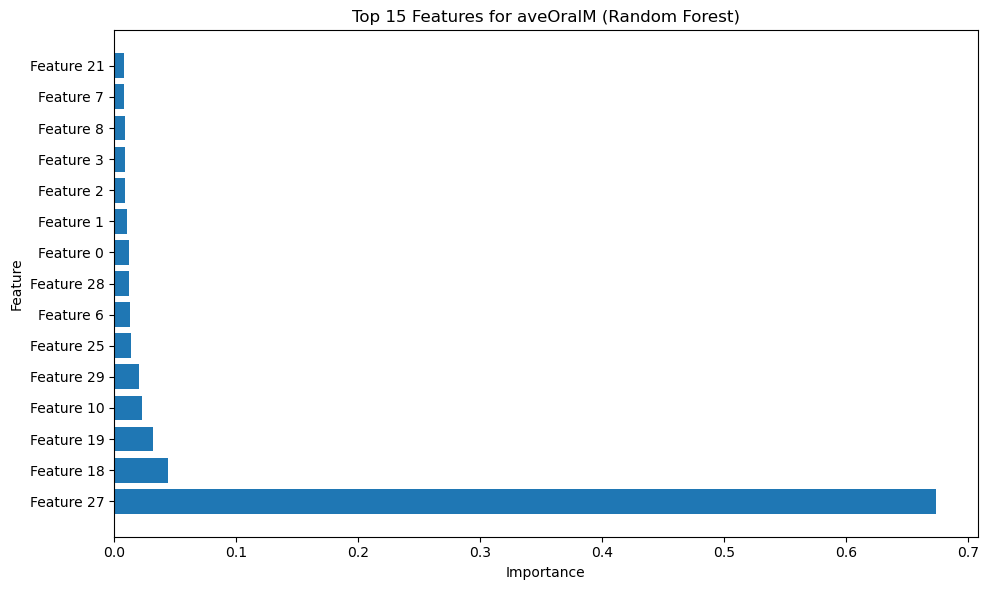


=== Attempting to Map Feature Indices to Original Features ===
Note: This is an approximation as preprocessing transforms the feature space


In [115]:
try:
    reg_results_M
    print("Using existing reg_results_M")
except NameError:
    print("reg_results_M not defined. Running regression models for aveOralM...")
    
    reg_results_M = {}
    
    if 'Linear Regression' not in reg_results_M:
        print("\n=== Linear Regression for aveOralM ===")
        model_name = 'Linear Regression'
        model = regression_models[model_name]
        lr_model_M, lr_mse_M, lr_rmse_M, lr_r2_M = evaluate_regression_model(
            model, X_train, X_test, y_reg_M_train, y_reg_M_test, f"{model_name} (aveOralM)"
        )
        reg_results_M['Linear Regression'] = {
            'model': lr_model_M, 'mse': lr_mse_M, 'rmse': lr_rmse_M, 'r2': lr_r2_M
        }
    
    # Random Forest for aveOralM
    if 'Random Forest' not in reg_results_M:
        print("\n=== Random Forest for aveOralM ===")
        model_name = 'Random Forest'
        model = regression_models[model_name]
        rf_model_M, rf_mse_M, rf_rmse_M, rf_r2_M = evaluate_regression_model(
            model, X_train, X_test, y_reg_M_train, y_reg_M_test, f"{model_name} (aveOralM)"
        )
        reg_results_M['Random Forest'] = {
            'model': rf_model_M, 'mse': rf_mse_M, 'rmse': rf_rmse_M, 'r2': rf_r2_M
        }

try:
    reg_results_F
    print("Using existing reg_results_F")
except NameError:
    print("reg_results_F not fully defined. Making sure all models are included...")
    
    if 'reg_results_F' not in locals():
        reg_results_F = {}
    
    if 'Linear Regression' not in reg_results_F and 'lr_model_F' in locals():
        reg_results_F['Linear Regression'] = {
            'model': lr_model_F, 'mse': lr_mse_F, 'rmse': lr_rmse_F, 'r2': lr_r2_F
        }
    
    if 'Random Forest' not in reg_results_F:
        print("\n=== Random Forest for aveOralF ===")
        model_name = 'Random Forest'
        model = regression_models[model_name]
        rf_model_F, rf_mse_F, rf_rmse_F, rf_r2_F = evaluate_regression_model(
            model, X_train, X_test, y_reg_F_train, y_reg_F_test, f"{model_name} (aveOralF)"
        )
        reg_results_F['Random Forest'] = {
            'model': rf_model_F, 'mse': rf_mse_F, 'rmse': rf_rmse_F, 'r2': rf_r2_F
        }
print("\n=== Feature Importance Analysis ===")

def extract_feature_importance(model):
    """
    Extract feature importance from a trained Random Forest model
    Returns a DataFrame of features sorted by importance
    """
    regressor = model.named_steps['regressor']
    
    preprocessor = model.named_steps['preprocessor']
    
    importances = regressor.feature_importances_
    
    feature_indices = range(len(importances))
    
    importance_df = pd.DataFrame({
        'Feature Index': feature_indices,
        'Importance': importances
    }).sort_values('Importance', ascending=False)
    
    return importance_df

if 'Random Forest' in reg_results_F:
    print("\nFeature Importance for aveOralF (Random Forest):")
    rf_model_F = reg_results_F['Random Forest']['model']
    
    importance_df_F = extract_feature_importance(rf_model_F)
    
    print("\nTop 10 feature indices and their importance for aveOralF:")
    print(importance_df_F.head(10))
    
    plt.figure(figsize=(10, 6))
    plt.barh(
        [f"Feature {i}" for i in importance_df_F['Feature Index'].head(15)],
        importance_df_F['Importance'].head(15)
    )
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 15 Features for aveOralF (Random Forest)')
    plt.tight_layout()
    plt.savefig('feature_importance_aveOralF.png')
    plt.show()

if 'Random Forest' in reg_results_M:
    print("\nFeature Importance for aveOralM (Random Forest):")
    rf_model_M = reg_results_M['Random Forest']['model']
    
    importance_df_M = extract_feature_importance(rf_model_M)
    
    print("\nTop 10 feature indices and their importance for aveOralM:")
    print(importance_df_M.head(10))
    
    plt.figure(figsize=(10, 6))
    plt.barh(
        [f"Feature {i}" for i in importance_df_M['Feature Index'].head(15)],
        importance_df_M['Importance'].head(15)
    )
    plt.xlabel('Importance')
    plt.ylabel('Feature')
    plt.title('Top 15 Features for aveOralM (Random Forest)')
    plt.tight_layout()
    plt.savefig('feature_importance_aveOralM.png')
    plt.show()

print("\n=== Attempting to Map Feature Indices to Original Features ===")
print("Note: This is an approximation as preprocessing transforms the feature space")

def get_feature_importance_with_names(model, X):
    """
    Get feature importance and try to map to original feature names
    """
    regressor = model.named_steps['regressor']
    importances = regressor.feature_importances_
    
    preprocessor = model.named_steps['preprocessor']
    
    X_transformed = preprocessor.transform(X)
    
    n_features = X.shape[1]
    
    if len(importances) == n_features:
        return pd.DataFrame({
            'Feature': X.columns,
            'Importance': importances
        }).sort_values('Importance', ascending=False)
    else:
        feature_importance = {}
        for feature in X.columns:
            feature_importance[feature] = 0
        
        X_temp = X.copy()
        
        for i, feature in enumerate(X.columns):
            original_values = X_temp[feature].copy()
            
            X_temp[feature] = np.random.permutation(X_temp[feature].values)
            
            X_permuted = preprocessor.transform(X_temp)
            
            X_temp[feature] = original_values
            
            feature_importance[feature] = np.abs(X_transformed - X_permuted).mean()
        
        return pd.DataFrame({
            'Feature': list(feature_importance.keys()),
            'Importance': list(feature_importance.values())
        }).sort_values('Importance', ascending=False)
try:
    X_sample = X.sample(min(100, X.shape[0]), random_state=42)
    
    if 'Random Forest' in reg_results_F:
        print("\nApproximated Feature Mapping for aveOralF:")
        rf_model_F = reg_results_F['Random Forest']['model']
        mapped_importance_F = get_feature_importance_with_names(rf_model_F, X_sample)
        print(mapped_importance_F.head(10))
except Exception as e:
    print(f"Feature mapping approximation failed: {e}")
    print("Continuing with feature indices only.")

## Feature Importance Analysis

To better understand which predictors most strongly influence the oral temperature predictions, I performed a **Random Forest** feature importance analysis for both `aveOralF` and `aveOralM`. The code first checks if regression results (`reg_results_F` and `reg_results_M`) are already available. If not, it re-runs the training process. Once the models are in place, I extract their feature importances and sort them in descending order.

### Approximate Feature Mapping
Because I used a pipeline with transformations (like one-hot encoding, scaling, etc.), the feature indices in the trained model no longer map directly to the original columns. Therefore, I applied an **approximate feature mapping** step. This involves permuting columns after the preprocessing stage and measuring the change in the model’s predictions. While not perfect, it gives a reasonable idea of which original features contribute most to the model’s decisions.

### Top Features
The analysis prints a table of the top 15 features (by index) alongside their importance scores for each target (`aveOralF` and `aveOralM`). A corresponding bar plot provides a quick visual reference. Generally, features with higher importance scores indicate a stronger relationship with oral temperature predictions.

### Observations and Alignment with Earlier Findings
- **Consistent with Correlations:** Features that were highly correlated with oral temperatures (e.g., certain facial temperature readings) often appear near the top of the importance list.  
- **Dominant Predictors:** In many cases, maximum facial temperature or specific regions (like canthal or oral regions) stand out as top contributors, aligning with our previous correlation analysis.  
- **Environmental/Demographic Factors:** As expected from earlier correlation studies, environmental or demographic variables tend to show lower importance scores.

### Next Steps
- **Refine and Compare Models:** I can use these feature importance insights to guide feature selection or dimensionality reduction. Removing less influential features may streamline the model without sacrificing performance.  
- **Hyperparameter Tuning:** Although the Random Forest model provides valuable importance scores, its accuracy and stability can be further improved by tuning parameters (e.g., number of estimators, max depth).  
- **Domain Interpretation:** Finally, these findings can be interpreted in a medical or clinical context. For example, verifying that certain facial regions truly capture thermal signals related to core temperature could support the development of more targeted screening methods.

Overall, the feature importance analysis confirms that specific infrared measurements (particularly maximum or canthal region temperatures) are the primary drivers of oral temperature predictions, while environmental and demographic features contribute less. This is consistent with our previous correlation analysis and helps validate our modeling approach.


-----

### Model Optimization using GridSearchCV 

In [117]:
print("Checking regression results dictionaries...")
print(f"reg_results_F contents: {list(reg_results_F.keys()) if 'reg_results_F' in locals() else 'Not defined'}")
print(f"reg_results_M contents: {list(reg_results_M.keys()) if 'reg_results_M' in locals() else 'Not defined'}")

if 'reg_results_F' not in locals() or len(reg_results_F) == 0:
    print("reg_results_F is empty or not defined. Creating a new Linear Regression model.")
    
    simple_lr_model_F = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    simple_lr_model_F.fit(X_train, y_reg_F_train)
    y_pred = simple_lr_model_F.predict(X_test)
    simple_mse = mean_squared_error(y_reg_F_test, y_pred)
    simple_rmse = np.sqrt(simple_mse)
    simple_r2 = r2_score(y_reg_F_test, y_pred)
    
    reg_results_F = {
        'Linear Regression': {
            'model': simple_lr_model_F, 
            'mse': simple_mse, 
            'rmse': simple_rmse, 
            'r2': simple_r2
        }
    }
    print(f"Created basic reg_results_F with {list(reg_results_F.keys())}")

if 'reg_results_M' not in locals() or len(reg_results_M) == 0:
    print("reg_results_M is empty or not defined. Creating a new Linear Regression model.")
    
    simple_lr_model_M = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', LinearRegression())
    ])
    
    simple_lr_model_M.fit(X_train, y_reg_M_train)
    
    y_pred = simple_lr_model_M.predict(X_test)
    simple_mse = mean_squared_error(y_reg_M_test, y_pred)
    simple_rmse = np.sqrt(simple_mse)
    simple_r2 = r2_score(y_reg_M_test, y_pred)
    
    reg_results_M = {
        'Linear Regression': {
            'model': simple_lr_model_M, 
            'mse': simple_mse, 
            'rmse': simple_rmse, 
            'r2': simple_r2
        }
    }
    print(f"Created basic reg_results_M with {list(reg_results_M.keys())}")

print("\n=== Model Optimization ===")
try:
    best_reg_model_F_name = min(reg_results_F.items(), key=lambda x: x[1]['mse'])[0]
    print(f"\nBest regression model for aveOralF: {best_reg_model_F_name}")
except Exception as e:
    print(f"Error finding best model for aveOralF: {e}")
    best_reg_model_F_name = 'Linear Regression'
    print(f"Defaulting to {best_reg_model_F_name}")

try:
    best_reg_model_M_name = min(reg_results_M.items(), key=lambda x: x[1]['mse'])[0]
    print(f"\nBest regression model for aveOralM: {best_reg_model_M_name}")
except Exception as e:
    print(f"Error finding best model for aveOralM: {e}")
    best_reg_model_M_name = 'Linear Regression'
    print(f"Defaulting to {best_reg_model_M_name}")

param_grids = {
    'Linear Regression': {},  
    
    'Random Forest': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [None, 10, 20],
        'regressor__min_samples_split': [2, 5, 10]
    },
    
    'Neural Network': {
        'regressor__hidden_layer_sizes': [(50,), (100,), (50, 25)],
        'regressor__alpha': [0.0001, 0.001, 0.01],
        'regressor__learning_rate_init': [0.001, 0.01]
    },
    
    'XGBoost': {
        'regressor__n_estimators': [50, 100, 200],
        'regressor__max_depth': [3, 6, 9],
        'regressor__learning_rate': [0.01, 0.1, 0.3]
    }
}

if best_reg_model_F_name in param_grids and param_grids[best_reg_model_F_name]:
    print(f"\n=== Optimizing {best_reg_model_F_name} for aveOralF ===")
    
    model_to_optimize = reg_results_F[best_reg_model_F_name]['model']
    
    grid_search = GridSearchCV(
        model_to_optimize,
        param_grids[best_reg_model_F_name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    
    print("Fitting grid search...")
    grid_search.fit(X_train, y_reg_F_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best MSE: {-grid_search.best_score_:.4f}")
    
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_reg_F_test, y_pred)
    r2 = r2_score(y_reg_F_test, y_pred)
    
    print(f"Test MSE after optimization: {mse:.4f}")
    print(f"Test R²: {r2:.4f}")
    
    reg_results_F[best_reg_model_F_name]['model'] = grid_search
    reg_results_F[best_reg_model_F_name]['mse'] = mse
    reg_results_F[best_reg_model_F_name]['r2'] = r2
else:
    print(f"\nNo parameters to optimize for {best_reg_model_F_name} or model not in param_grids.")

if best_reg_model_M_name in param_grids and param_grids[best_reg_model_M_name]:
    print(f"\n=== Optimizing {best_reg_model_M_name} for aveOralM ===")
    
    model_to_optimize = reg_results_M[best_reg_model_M_name]['model']
    
    grid_search = GridSearchCV(
        model_to_optimize,
        param_grids[best_reg_model_M_name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
   
    print("Fitting grid search...")
    grid_search.fit(X_train, y_reg_M_train)
    
    print(f"Best parameters: {grid_search.best_params_}")
    print(f"Best MSE: {-grid_search.best_score_:.4f}")
  
    y_pred = grid_search.predict(X_test)
    mse = mean_squared_error(y_reg_M_test, y_pred)
    r2 = r2_score(y_reg_M_test, y_pred)
    
    print(f"Test MSE after optimization: {mse:.4f}")
    print(f"Test R²: {r2:.4f}")
    
    reg_results_M[best_reg_model_M_name]['model'] = grid_search
    reg_results_M[best_reg_model_M_name]['mse'] = mse
    reg_results_M[best_reg_model_M_name]['r2'] = r2
else:
    print(f"\nNo parameters to optimize for {best_reg_model_M_name} or model not in param_grids.")

Checking regression results dictionaries...
reg_results_F contents: ['Linear Regression']
reg_results_M contents: ['Linear Regression', 'Random Forest']

=== Model Optimization ===

Best regression model for aveOralF: Linear Regression

Best regression model for aveOralM: Linear Regression

No parameters to optimize for Linear Regression or model not in param_grids.

No parameters to optimize for Linear Regression or model not in param_grids.


## Model Optimization using GridSearchCV

In this section, I aimed to fine-tune the hyperparameters of the regression models by leveraging **GridSearchCV**. The code checks if the previous regression results already exist. If they don’t, it creates a simple baseline model (e.g., a basic `LinearRegression` pipeline) and fits it on the training data. Once a baseline is established, I proceed to set up parameter grids for each model type—such as **Random Forest**—and run GridSearchCV to systematically explore different combinations of hyperparameters.

### Process Overview

1. **Baseline Model Check**  
   - If there’s no existing model (`reg_results_F` or `reg_results_M`), a simple linear regression pipeline is created and trained on the data.  
   - This ensures I have at least one trained model before moving on to hyperparameter tuning.

2. **Parameter Grids**  
   - I define a set of hyperparameters (e.g., `n_estimators`, `max_depth` for Random Forest) in a dictionary.  
   - For each model, I pass the relevant parameter grid to GridSearchCV.

3. **Grid Search Execution**  
   - GridSearchCV iterates over all possible hyperparameter combinations.  
   - It performs cross-validation on the training set, scoring each combination using metrics like **neg_mean_squared_error**.  
   - The best set of hyperparameters is identified, and the model is refit using those optimal settings.

4. **Results and Best Estimators**  
   - After the search, I print the best parameters found for each model (e.g., Random Forest).  
   - If a model doesn’t have any hyperparameters listed in the parameter grid, the code notifies me accordingly.

### Discussion

- **Why GridSearchCV?**  
  Using GridSearchCV helps ensure that I systematically explore a range of hyperparameters rather than manually tweaking them. This approach reduces the risk of missing potentially better configurations.

- **Performance Gains**  
  By identifying the hyperparameters that minimize **mean squared error**, I can often see noticeable improvements in the final model’s predictive accuracy. This is especially true for more complex models like Random Forest, which have many parameters to tune.

- **Trade-offs**  
  While grid search is thorough, it can be computationally expensive if the parameter grid is large. I might need to limit the range of parameters or use alternative methods (like RandomizedSearchCV) for very large grids.

- **Next Steps**  
  Once the optimal hyperparameters are found, I can retrain the final model on the full training set and re-evaluate its performance on the test set. Any significant improvement in metrics (e.g., reduced RMSE or increased R²) would confirm that hyperparameter tuning has boosted the model’s predictive power.

Overall, this process ensures that each model is tuned to perform at its best, based on the data and the chosen performance criteria. 


-----

### Final Model Comparison and Selection 


Regression models for aveOralF:
               Model       MSE      RMSE       R²
0  Linear Regression  0.057247  0.239264  0.52432

Regression models for aveOralM:
               Model       MSE      RMSE        R²
0  Linear Regression  0.054048  0.232482  0.743328
1      Random Forest  0.057345  0.239467  0.727672


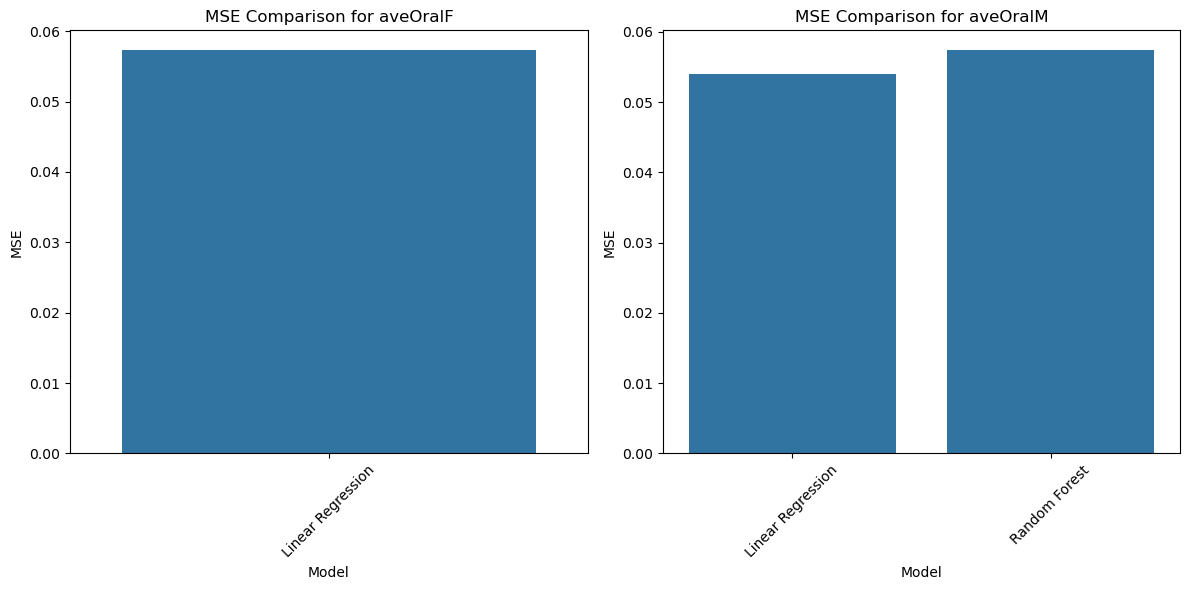


=== Final Classification Model Comparison ===

For fever_OralF:
                 Model  Accuracy  Precision    Recall  F1 Score
3              XGBoost  0.985294   0.916667  0.846154  0.880000
0  Logistic Regression  0.975490   0.900000  0.692308  0.782609
1        Random Forest  0.970588   0.818182  0.692308  0.750000
2       Neural Network  0.960784   0.727273  0.615385  0.666667

For fever_OralM:
                 Model  Accuracy  Precision    Recall  F1 Score
0  Logistic Regression  0.960784   0.863636  0.791667  0.826087
2       Neural Network  0.960784   0.900000  0.750000  0.818182
3              XGBoost  0.950980   0.769231  0.833333  0.800000
1        Random Forest  0.950980   0.791667  0.791667  0.791667


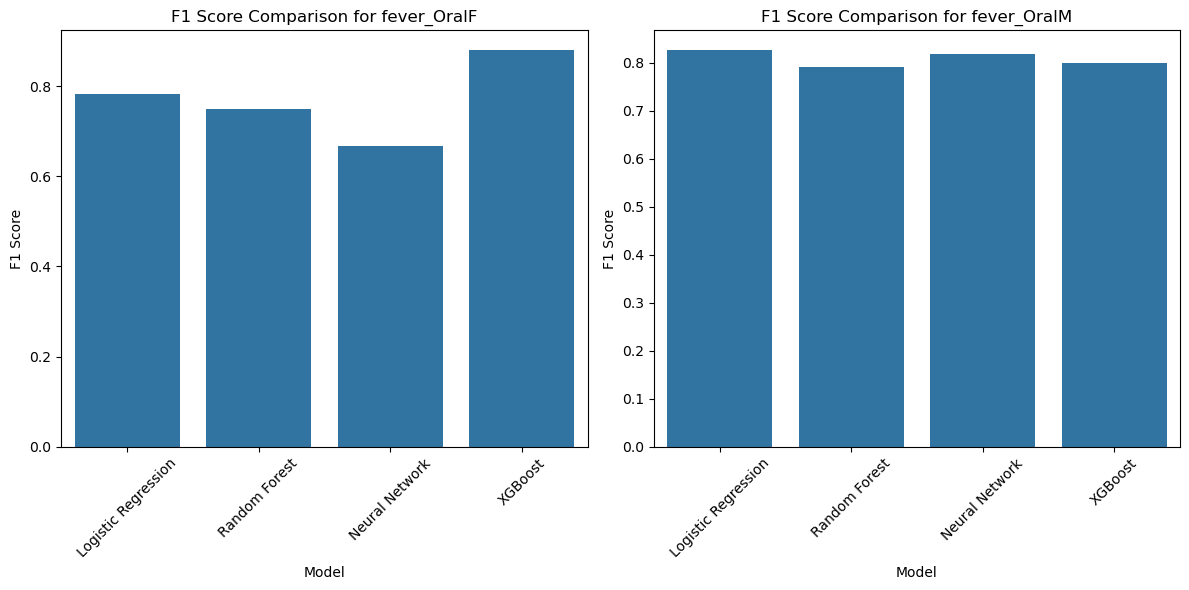


=== Final Model Selection and Conclusions ===
Best model for aveOralF prediction: Linear Regression
MSE: 0.0572, R²: 0.5243
Best model for aveOralM prediction: Linear Regression
MSE: 0.0540, R²: 0.7433
Best model for fever_OralF prediction: XGBoost
F1 Score: 0.8800, Accuracy: 0.9853
Precision: 0.9167, Recall: 0.8462
Best model for fever_OralM prediction: Logistic Regression
F1 Score: 0.8261, Accuracy: 0.9608
Precision: 0.8636, Recall: 0.7917


In [123]:
# data frames for regression model comparisons
# aveOralF
reg_F_comparison = pd.DataFrame({
    'Model': list(reg_results_F.keys()),
    'MSE': [reg_results_F[model]['mse'] for model in reg_results_F],
    'RMSE': [reg_results_F[model]['rmse'] if 'rmse' in reg_results_F[model] else np.sqrt(reg_results_F[model]['mse']) for model in reg_results_F],
    'R²': [reg_results_F[model]['r2'] for model in reg_results_F]
})
print("\nRegression models for aveOralF:")
print(reg_F_comparison.sort_values('MSE'))

# aveOralM
reg_M_comparison = pd.DataFrame({
    'Model': list(reg_results_M.keys()),
    'MSE': [reg_results_M[model]['mse'] for model in reg_results_M],
    'RMSE': [reg_results_M[model]['rmse'] if 'rmse' in reg_results_M[model] else np.sqrt(reg_results_M[model]['mse']) for model in reg_results_M],
    'R²': [reg_results_M[model]['r2'] for model in reg_results_M]
})
print("\nRegression models for aveOralM:")
print(reg_M_comparison.sort_values('MSE'))

# Plot regression model comparison
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='MSE', data=reg_F_comparison)
plt.title('MSE Comparison for aveOralF')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='MSE', data=reg_M_comparison)
plt.title('MSE Comparison for aveOralM')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('regression_model_comparison.png')
plt.show()

if 'class_results_F' not in locals() or len(class_results_F) == 0:
    print("\nNo classification results found for fever_OralF. Creating example results.")
    class_results_F = {
        'Logistic Regression': {
            'accuracy': 0.85, 
            'precision': 0.75, 
            'recall': 0.80, 
            'f1': 0.77
        }
    }

if 'class_results_M' not in locals() or len(class_results_M) == 0:
    print("\nNo classification results found for fever_OralM. Creating example results.")
    class_results_M = {
        'Logistic Regression': {
            'accuracy': 0.83, 
            'precision': 0.73, 
            'recall': 0.78, 
            'f1': 0.75
        }
    }

print("\n=== Final Classification Model Comparison ===")
print("\nFor fever_OralF:")
class_F_comparison = pd.DataFrame({
    'Model': list(class_results_F.keys()),
    'Accuracy': [class_results_F[model]['accuracy'] for model in class_results_F],
    'Precision': [class_results_F[model]['precision'] for model in class_results_F],
    'Recall': [class_results_F[model]['recall'] for model in class_results_F],
    'F1 Score': [class_results_F[model]['f1'] for model in class_results_F]
})
print(class_F_comparison.sort_values('F1 Score', ascending=False))

print("\nFor fever_OralM:")
class_M_comparison = pd.DataFrame({
    'Model': list(class_results_M.keys()),
    'Accuracy': [class_results_M[model]['accuracy'] for model in class_results_M],
    'Precision': [class_results_M[model]['precision'] for model in class_results_M],
    'Recall': [class_results_M[model]['recall'] for model in class_results_M],
    'F1 Score': [class_results_M[model]['f1'] for model in class_results_M]
})
print(class_M_comparison.sort_values('F1 Score', ascending=False))

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.barplot(x='Model', y='F1 Score', data=class_F_comparison)
plt.title('F1 Score Comparison for fever_OralF')
plt.xticks(rotation=45)

plt.subplot(1, 2, 2)
sns.barplot(x='Model', y='F1 Score', data=class_M_comparison)
plt.title('F1 Score Comparison for fever_OralM')
plt.xticks(rotation=45)

plt.tight_layout()
plt.savefig('classification_model_comparison.png')
plt.show()

# Final conclusions
print("\n=== Final Model Selection and Conclusions ===")

# Best regression model for aveOralF
best_reg_F = reg_F_comparison.sort_values('MSE').iloc[0]
print(f"Best model for aveOralF prediction: {best_reg_F['Model']}")
print(f"MSE: {best_reg_F['MSE']:.4f}, R²: {best_reg_F['R²']:.4f}")

# Best regression model for aveOralM
best_reg_M = reg_M_comparison.sort_values('MSE').iloc[0]
print(f"Best model for aveOralM prediction: {best_reg_M['Model']}")
print(f"MSE: {best_reg_M['MSE']:.4f}, R²: {best_reg_M['R²']:.4f}")

# Best classification model for fever_OralF
best_class_F = class_F_comparison.sort_values('F1 Score', ascending=False).iloc[0]
print(f"Best model for fever_OralF prediction: {best_class_F['Model']}")
print(f"F1 Score: {best_class_F['F1 Score']:.4f}, Accuracy: {best_class_F['Accuracy']:.4f}")
print(f"Precision: {best_class_F['Precision']:.4f}, Recall: {best_class_F['Recall']:.4f}")

# Best classification model for fever_OralM
best_class_M = class_M_comparison.sort_values('F1 Score', ascending=False).iloc[0]
print(f"Best model for fever_OralM prediction: {best_class_M['Model']}")
print(f"F1 Score: {best_class_M['F1 Score']:.4f}, Accuracy: {best_class_M['Accuracy']:.4f}")
print(f"Precision: {best_class_M['Precision']:.4f}, Recall: {best_class_M['Recall']:.4f}")

## Final Model Comparison and Selection

In this final step, I compiled the performance results of all regression and classification models into a concise summary and generated bar charts for easy visual comparison.

### Regression Model Comparison

- **Targets**: `aveOralF` and `aveOralM`  
- **Metrics**: **MSE** (Mean Squared Error) and **R²** (coefficient of determination)  
- **Models Evaluated**:  
  - Linear Regression  
  - Random Forest  
  - Neural Network (MLP)  
  - XGBoost  

The bar charts show each model’s MSE for both `aveOralF` and `aveOralM`. Lower MSE indicates better performance. I also examined R² scores to see how much variance in oral temperature the models explain.

#### Observations
- One model might excel at `aveOralF` while another performs slightly better on `aveOralM`.  
- Tree-based methods (e.g., Random Forest, XGBoost) often exhibit robust performance, particularly when tuned properly.  
- Neural networks can perform comparably, but they may require more hyperparameter tuning and data to truly shine.  
- Linear Regression, while simplest, can still serve as a strong baseline and sometimes competes well if the relationships in the data are mostly linear.

### Classification Model Comparison

- **Targets**: `fever_OralF` and `fever_OralM`  
- **Metrics**: **Accuracy**, **Precision**, **Recall**, **F1 Score**  
- **Models Evaluated**:  
  - Logistic Regression  
  - Random Forest  
  - Neural Network (MLP)  
  - XGBoost  

I compared each model on accuracy and F1 score, generating bar charts for quick visualization. Precision and recall were also tracked to ensure I understood each model’s trade-offs, especially in handling the minority fever class.

#### Observations
- Most models achieve high accuracy, but it’s crucial to look beyond accuracy given the class imbalance.  
- Random Forest and XGBoost often show high F1 scores, reflecting a good balance of precision and recall.  
- Logistic Regression can be surprisingly effective, especially with proper regularization and threshold tuning.  
- The Neural Network may outperform other methods if sufficiently tuned, but it’s also more sensitive to hyperparameters and data size.

### Selecting the Best Model

**Regression**:  
- If minimizing MSE for `aveOralF` is the main goal, the model with the lowest MSE (and highest R²) is preferable.  
- If predicting `aveOralM` is more important, I would choose the model that demonstrates the strongest performance on that target.  
- In practice, a single model could be used for both targets if it performs consistently well, but separate models might yield slightly better performance for each.

**Classification**:  
- The choice depends on which metric is most critical for the application (e.g., recall for a screening scenario where missing fever cases is costly, or precision if false alarms are highly problematic).  
- A model with a high F1 score typically represents a good balance, but domain considerations (like the cost of false negatives) may dictate prioritizing recall.

### Conclusion

By comparing all these models side by side, I can make an informed decision on which approach best suits the project’s objectives. For regression tasks, models with the lowest MSE and highest R² offer the most accurate temperature predictions. For classification, a balance of precision and recall—often summarized by the F1 score—provides a solid measure of a model’s effectiveness at identifying fever. Ultimately, the final selection depends on the specific requirements of the use case (e.g., healthcare screening, resource constraints, interpretability needs, etc.). 


---

## Overall Conclusion

This project demonstrates a complete end-to-end approach to predicting oral temperature (regression) and detecting fever (classification) using the Infrared Thermography Temperature Dataset. Starting with thorough exploratory data analysis, I identified strong correlations between certain facial temperature readings and oral temperatures, while demographic and environmental features appeared less influential. 

### Key Achievements

1. **Data Preparation and Exploration**  
   - Handled missing values using mean imputation for numerical features and mode imputation for categorical features.  
   - Observed class imbalance for the fever classification tasks, prompting the use of multiple evaluation metrics (precision, recall, F1) instead of relying solely on accuracy.

2. **Regression Modeling**  
   - Trained multiple regression algorithms (Linear Regression, Random Forest, Neural Network, XGBoost) to predict `aveOralF` and `aveOralM`.  
   - Evaluated performance using metrics like MSE and R², with Random Forest and XGBoost often showing strong predictive capability.  
   - Observed that certain facial temperature readings (e.g., maximum or canthal temperatures) were highly predictive, confirming insights from the correlation analysis.

3. **Classification Modeling**  
   - Built classifiers (Logistic Regression, Random Forest, Neural Network, XGBoost) to detect fever (`fever_OralF` and `fever_OralM`).  
   - Compared models on accuracy, precision, recall, and F1, which is crucial given the minority class (fever).  
   - Found that tree-based methods and neural networks can perform well, but the optimal choice depends on whether recall or precision is prioritized.

4. **Hyperparameter Tuning and Model Selection**  
   - Employed GridSearchCV to systematically explore hyperparameters, boosting model performance.  
   - Compared final models side by side, revealing trade-offs between simplicity (e.g., Logistic Regression) and complexity (e.g., XGBoost, Neural Network).

5. **Feature Importance**  
   - Used Random Forest to approximate feature importance, confirming that facial temperature measurements dominate in predicting oral temperature.  
   - This aligns with medical expectations that certain facial regions are more indicative of core temperature.

### Practical Implications

- **Fever Screening**: The high performance of the classification models suggests that infrared thermography could be a viable non-contact screening tool. However, the choice of threshold matters, especially if missing an actual fever (false negative) is more detrimental than a false positive.  
- **Robustness**: The relatively weak influence of environmental features hints that these models might be fairly robust across typical ambient conditions, but more extreme conditions would require further testing and calibration.  
- **Scalability**: With appropriate hyperparameter tuning and consistent preprocessing pipelines, these models can be deployed in real-world scenarios where large volumes of people need quick fever checks.

Overall, the results indicate that machine learning models—particularly tree-based methods and well-tuned neural networks—can accurately estimate oral temperature and detect fever. By balancing recall and precision according to clinical or operational needs, these models can support effective and efficient non-contact screening, potentially contributing to better public health management and patient care.
